In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [119]:
import itertools
import sys
sys.path.insert(0, '..')
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 16
import numpy as np
import pandas as pd
import requests
import seaborn as sns

import covid19

## data

In [120]:
deaths_path = 'time_series_covid19_deaths_US.csv'
deaths_path = covid19.data.download('deaths', repo='usa')
confirmed_path = 'time_series_covid19_deaths_US.csv'
confirmed_path = covid19.data.download('confirmed', repo='usa')
deaths_path, confirmed_path

('time_series_covid19_deaths_US.csv', 'time_series_covid19_confirmed_US.csv')

In [121]:
ds_counties = covid19.data.read_jhu_usa(deaths_path)
ds_counties['confirmed'] = covid19.data.read_jhu_usa(confirmed_path)['confirmed']
ds_counties['mortality'] = ds_counties['deaths'] / ds_counties['population'] * 1_000_000
ds_counties['daily_deaths'] = ds_counties['deaths'].diff('time')
ds_counties['daily_mortality'] = ds_counties['daily_deaths'] / ds_counties['population'] * 1_000_000
ds_counties['daily_mortality7'] = ds_counties['daily_mortality'].rolling({'time': 7}).mean()
ds_counties['daily_confirmed'] = ds_counties['confirmed'].diff('time')
ds_counties['daily_prevalence'] = ds_counties['daily_confirmed'] / ds_counties['population'] * 1_000_000
ds_counties['daily_prevalence7'] = ds_counties['daily_prevalence'].rolling({'time': 7}).mean()

ds_counties = ds_counties.fillna(0)
ds_counties

<xarray.Dataset>
Dimensions:            (location: 3340, time: 222)
Coordinates:
  * time               (time) datetime64[ns] 2020-01-22 ... 2020-08-30
    state_region       (location) <U29 'US / Alabama' ... 'US / Wyoming'
    country            (location) <U2 'US' 'US' 'US' 'US' ... 'US' 'US' 'US'
    lat                (location) float64 32.54 30.73 31.87 ... 0.0 43.9 43.84
    lon                (location) float64 -86.64 -87.72 -85.39 ... -107.7 -104.6
  * location           (location) <U57 'US / Alabama / Autauga' ... 'US / Wyoming / Weston'
Data variables:
    population         (location) int64 55869 223234 24686 22394 ... 0 7805 6927
    deaths             (time, location) int64 0 0 0 0 0 0 0 0 ... 0 0 0 0 36 0 0
    confirmed          (time, location) int64 0 0 0 0 0 0 ... 429 295 73 108 11
    mortality          (time, location) float64 0.0 0.0 0.0 0.0 ... inf 0.0 0.0
    daily_deaths       (time, location) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    daily_mortality    (time, location) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    daily_mortality7   (time, location) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    daily_confirmed    (time, location) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    daily_prevalence   (time, location) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    daily_prevalence7  (time, location) float64 0.0 0.0 0.0 ... 3.248e-14 0.0

In [122]:
tmp = ds_counties.sortby(-ds_counties['daily_mortality7'].isel(time=-1)).isel(time=-1)
tmp.sel(location=tmp['population'] > 100_000).to_dataframe().head(20)

population  deaths  confirmed    mortality  \
location                                                                        
US / Texas / Cameron                   423163     752      20853  1777.092988   
US / South Carolina / Anderson         202558     120       3146   592.422911   
US / Georgia / Bibb                    153159     119       5375   776.970338   
US / Florida / Highlands               106221      67       1821   630.760396   
US / Florida / Indian River            159923      98       2834   612.794908   
US / California / Imperial             181215     293      10667  1616.863946   
US / Texas / Nueces                    362294     352      18830   971.586612   
US / Florida / Marion                  365579     179       8469   489.634251   
US / Mississippi / Rankin              155271      63       2842   405.742218   
US / Texas / Hidalgo                   868707    1162      27408  1337.620164   
US / Arizona / Yuma                    213787     321      12230  1501.494478   
US / Georgia / Lowndes                 117406      65       3468   553.634397   
US / Texas / Tom Green                 119200      52       3217   436.241611   
US / Florida / Citrus                  149657      57       2082   380.870925   
US / Texas / Webb                      276652     243      10814   878.359817   
US / Florida / Hernando                193920      83       2601   428.011551   
US / Georgia / Muscogee                195769     134       5440   684.480178   
US / South Carolina / Spartanburg      319785     149       4994   465.938052   
US / Louisiana / Tangipahoa            134758      97       4030   719.808843   
US / Florida / St. Lucie               328297     235       6975   715.815253   

                                   daily_deaths  daily_mortality  \
location                                                           
US / Texas / Cameron                        6.0        14.178933   
US / South Carolina / Anderson              0.0         0.000000   
US / Georgia / Bibb                         1.0         6.529163   
US / Florida / Highlands                    0.0         0.000000   
US / Florida / Indian River                 0.0         0.000000   
US / California / Imperial                  0.0         0.000000   
US / Texas / Nueces                         4.0        11.040757   
US / Florida / Marion                       5.0        13.676934   
US / Mississippi / Rankin                   1.0         6.440353   
US / Texas / Hidalgo                        6.0         6.906817   
US / Arizona / Yuma                         2.0         9.355106   
US / Georgia / Lowndes                      0.0         0.000000   
US / Texas / Tom Green                      1.0         8.389262   
US / Florida / Citrus                       0.0         0.000000   
US / Texas / Webb                           1.0         3.614649   
US / Florida / Hernando                     0.0         0.000000   
US / Georgia / Muscogee                     1.0         5.108061   
US / South Carolina / Spartanburg           1.0         3.127101   
US / Louisiana / Tangipahoa                 3.0        22.262129   
US / Florida / St. Lucie                    0.0         0.000000   

                                   daily_mortality7  daily_confirmed  \
location                                                               
US / Texas / Cameron                      33.421772              0.0   
US / South Carolina / Anderson            19.747430             25.0   
US / Georgia / Bibb                       19.587488            -13.0   
US / Florida / Highlands                  18.828669             10.0   
US / Florida / Indian River               16.972454              7.0   
US / California / Imperial                16.554921              0.0   
US / Texas / Nueces                       15.378197            166.0   
US / Florida / Marion                     14.849243             45.0   
US / Mississippi / Rankin          

In [123]:
ds_states = ds_counties.groupby('state_region').sum().rename({'state_region': 'location'})
ds_states['mortality'] = ds_states['deaths'] / ds_states['population'] * 1_000_000
ds_states['daily_mortality'] = ds_states['daily_deaths'] / ds_states['population'] * 1_000_000
ds_states['daily_mortality7'] = ds_states['daily_mortality'].rolling({'time': 7}).mean()
ds_states['daily_prevalence'] = ds_states['daily_confirmed'] / ds_states['population'] * 1_000_000
ds_states['daily_prevalence7'] = ds_states['daily_prevalence'].rolling({'time': 7}).mean()
tmp = ds_states.isel(time=-1).copy()
tmp = tmp.sortby(-tmp['daily_prevalence7'])
STATES = list(tmp.location.values)
tmp.to_dataframe().head(50)

time  population  deaths  confirmed  \
location                                                              
US / Guam                 2020-08-30      164229      10       1287   
US / Iowa                 2020-08-30     3155070    1113      64599   
US / North Dakota         2020-08-30      762062     142      11702   
US / South Dakota         2020-08-30      884659     167      13322   
US / Alabama              2020-08-30     4903185    2162     125235   
US / Mississippi          2020-08-30     2976149    2441      82676   
US / Arkansas             2020-08-30     3017804     784      60856   
US / Georgia              2020-08-30    10617423    5604     268973   
US / Kansas               2020-08-30     2913314     449      41761   
US / Virgin Islands       2020-08-30      107268      14       1129   
US / Tennessee            2020-08-30     6829174    1747     153115   
US / Missouri             2020-08-30     6626371    1533      84474   
US / Oklahoma             2020-08-30     3956971     799      58119   
US / South Carolina       2020-08-30     5148714    2709     118324   
US / Hawaii               2020-08-30     1415872      63       8339   
US / Texas                2020-08-30    28995881   12683     629570   
US / Idaho                2020-08-30     1787065     359      31858   
US / Nebraska             2020-08-30     1934408     392      34046   
US / Kentucky             2020-08-30     4467673     929      48031   
US / Indiana              2020-08-30     6732219    3291      93313   
US / Nevada               2020-08-30     3080156    1302      68908   
US / Illinois             2020-08-30    12671821    8228     235058   
US / Louisiana            2020-08-30     4648794    4931     147867   
US / North Carolina       2020-08-30    10488084    2692     166127   
US / Minnesota            2020-08-30     5639632    1865      75189   
US / Florida              2020-08-30    21477737   11119     621586   
US / California           2020-08-30    39512223   12937     705951   
US / Utah                 2020-08-30     3205958     407      51854   
US / Montana              2020-08-30     1068778     104       7340   
US / Wisconsin            2020-08-30     5822434    1122      75337   
US / Virginia             2020-08-30     8535519    2569     119729   
US / Puerto Rico          2020-08-30     3754939     434      32848   
US / Alaska               2020-08-30      731545      37       5226   
US / Ohio                 2020-08-30    11689100    4129     122260   
US / Rhode Island         2020-08-30     1059361    1046      21683   
US / Maryland             2020-08-30     6045680    3752     107791   
US / Michigan             2020-08-30     9986857    6748     112526   
US / District of Columbia 2020-08-30      705749     606      13959   
US / Arizona              2020-08-30     7278717    5030     201661   
US / West Virginia        2020-08-30     1792147     214      10109   
US / Delaware             2020-08-30      973764     604      17343   
US / Washington           2020-08-30     7614893    1905      74320   
US / Wyoming              2020-08-30      578759      37       3829   
US / New Mexico           2020-08-30     2096829     770      25283   
US / Massachusetts        2020-08-30     6892503    9049     128229   
US / Oregon               2020-08-30     4217737     458      26554   
US / Colorado             2020-08-30     5758736    1942      57203   
US / Pennsylvania         2020-08-30    12801989    7658     138134   
US / Connecticut          2020-08-30     3565287    4465      52495   
US / New Jersey           2020-08-30     8882190   15937     191611   

                             mortality  daily_deaths  daily_mortality  \
location                                                                
US / Guam                    60.890586           0.0         0.000000   
US / Iowa                   352.765549          13.0         4.120352   
US / North Dakota           186.336545         

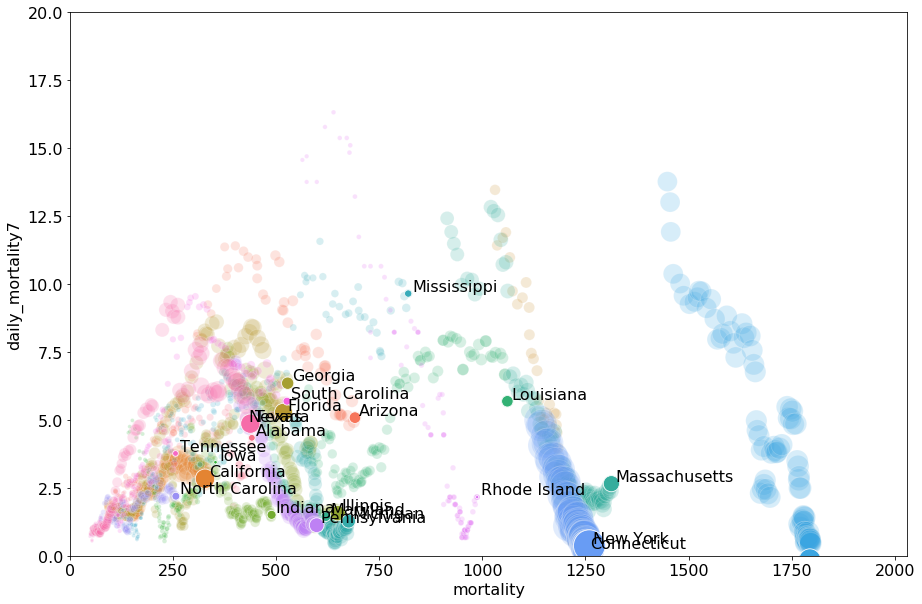

In [124]:
# sns.set()

world_hit = ds_states.sel(location=(((ds_states['daily_mortality7'].isel(time=-1) > 2.) | (ds_states['mortality'] > 400).any('time')) & (ds_states['deaths'] > 1_000)).any('time')).isel(time=slice(-100, None)).to_dataframe().reset_index()
ax = sns.scatterplot(x="mortality", y="daily_mortality7", hue="location", size="deaths", data=world_hit, alpha=0.2, sizes=(10, 1_000), legend=False)
ax = sns.scatterplot(x="mortality", y="daily_mortality7", hue="location", size="deaths", data=world_hit[world_hit['time']==world_hit['time'].max()], sizes=(10, 1_000), legend=False)
_ = ax.set(ylim=(0, 20), xlim=(0, 2030))
for index in world_hit[world_hit['time']==world_hit['time'].max()].index:
    record = world_hit.loc[index]
    ax.annotate(record['location'].partition('US / ')[2], (record['mortality'] + 10, record['daily_mortality7'] + .1))

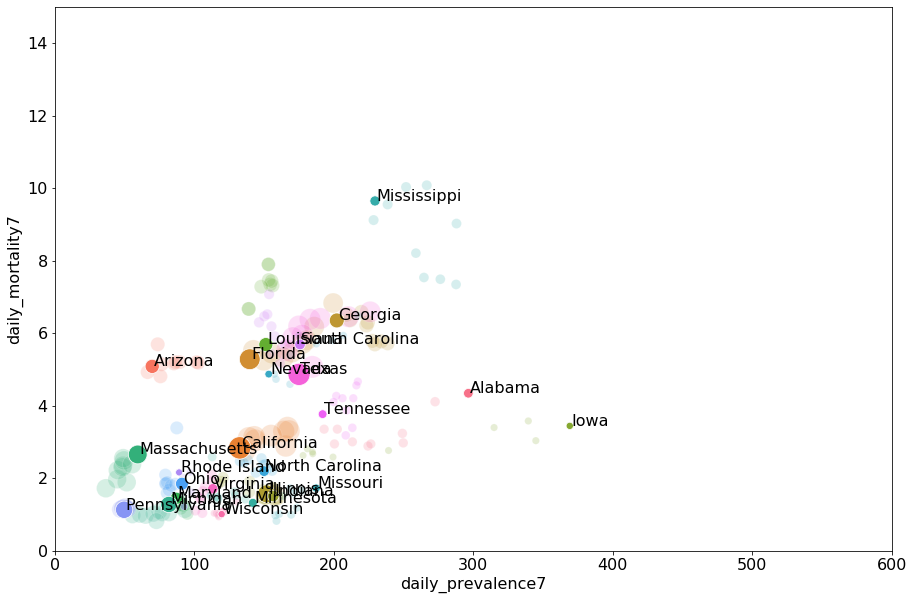

In [125]:
world_hit = ds_states.sel(location=(((ds_states['daily_mortality7'].isel(time=-1) > 1.) & (ds_states['mortality'] > 0).any('time')) & (ds_states['deaths'] > 1_000)).any('time')).isel(time=slice(-10, None)).to_dataframe().reset_index()
ax = sns.scatterplot(x="daily_prevalence7", y="daily_mortality7", hue="location", size="deaths", data=world_hit, alpha=0.2, sizes=(50, 500), legend=False)
ax = sns.scatterplot(x="daily_prevalence7", y="daily_mortality7", hue="location", size="deaths", data=world_hit[world_hit['time']==world_hit['time'].max()], sizes=(50, 500), legend=False)
_ = ax.set(ylim=(0, 15), xlim=(0, 600))
for index in world_hit[world_hit['time']==world_hit['time'].max()].index:
    record = world_hit.loc[index]
    if record['daily_mortality7'] > 15:
        continue
    ax.annotate(record['location'].partition('US / ')[2], (record['daily_prevalence7'] + 1, record['daily_mortality7'] + .01))

In [126]:
#### DAY = np.timedelta64(24 * 60 * 60, 's')
PALETTE_ONE = list(sns.color_palette())


EXTENT = ('2020-03-12', '2020-09-05')
XLIM = tuple(map(np.datetime64, EXTENT))

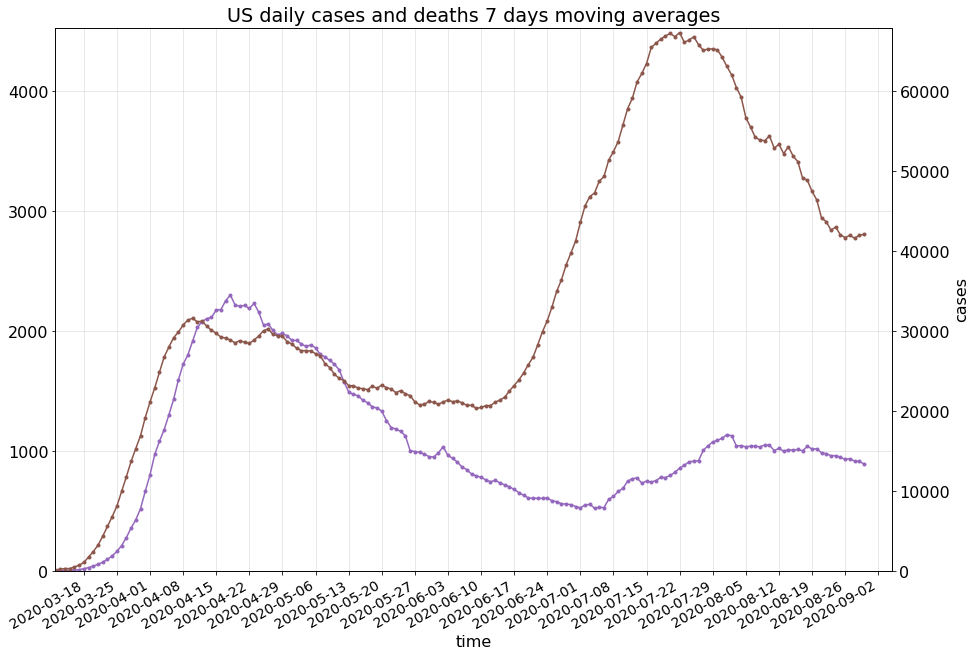

In [127]:
_, ax1 = covid19.plot.subplots(subplot_kw={'xlim': XLIM})
ax1.set(title=f'COVID-19 USA - Linear scale')
ax2 = ax1.twinx()

usa = ds_states.sum('location')

covid19.plot.plot_data(ax1, usa['daily_deaths'].rolling({'time': 7}).mean())
covid19.plot.plot_data(ax2, usa['daily_confirmed'].rolling({'time': 7}).mean())

ax1.set(ylim=(0, usa['population'] / 15 / 5_000), title='US daily cases and deaths 7 days moving averages') 
_ = ax2.set(ylim=(0, usa['population'] / 5_000), ylabel='cases') 


pippo
time              
2020-01-22     NaN
2020-01-23     NaN
2020-01-24     NaN
2020-01-25     NaN
2020-01-26     NaN
...            ...
2020-08-26  6531.0
2020-08-27  6569.0
2020-08-28  6433.0
2020-08-29  6411.0
2020-08-30  6266.0

[222 rows x 1 columns]

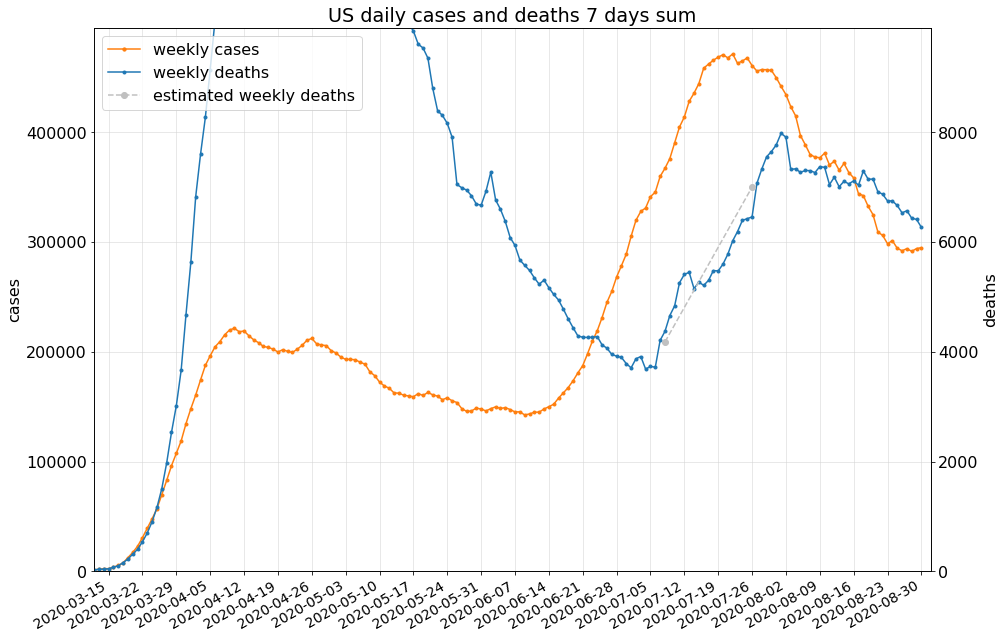

In [128]:
fig, ax1 = covid19.plot.subplots(subplot_kw={'xlim': tuple(map(np.datetime64, ('2020-03-12', '2020-09-01')))})
ax2 = ax1.twinx()

usa = ds_states.sum('location')

ax2.plot([0], [0], 'o-', color='tab:orange', label='weekly cases', markersize=3.25)
covid19.plot.plot_data(ax2, usa['daily_deaths'].rolling({'time': 7}).sum(), color='tab:blue', label='weekly deaths')
covid19.plot.plot_data(ax1, usa['daily_confirmed'].rolling({'time': 7}).sum(), color='tab:orange')
ax2.plot(tuple(map(np.datetime64, ['2020-07-08', '2020-07-26'])), [4180, 7000], 'o--', color='silver', label='estimated weekly deaths')


ax2.set(ylim=(0, 9900), title='US daily cases and deaths 7 days sum', ylabel='deaths') 
ax1.yaxis.set_label_position("left")
ax2.legend(loc='upper left')
_ = ax1.set(ylim=(0, 9900 * 50), ylabel='cases', xlabel='') 
usa['daily_deaths'].rolling({'time': 7}).sum().rename('pippo').to_dataframe()

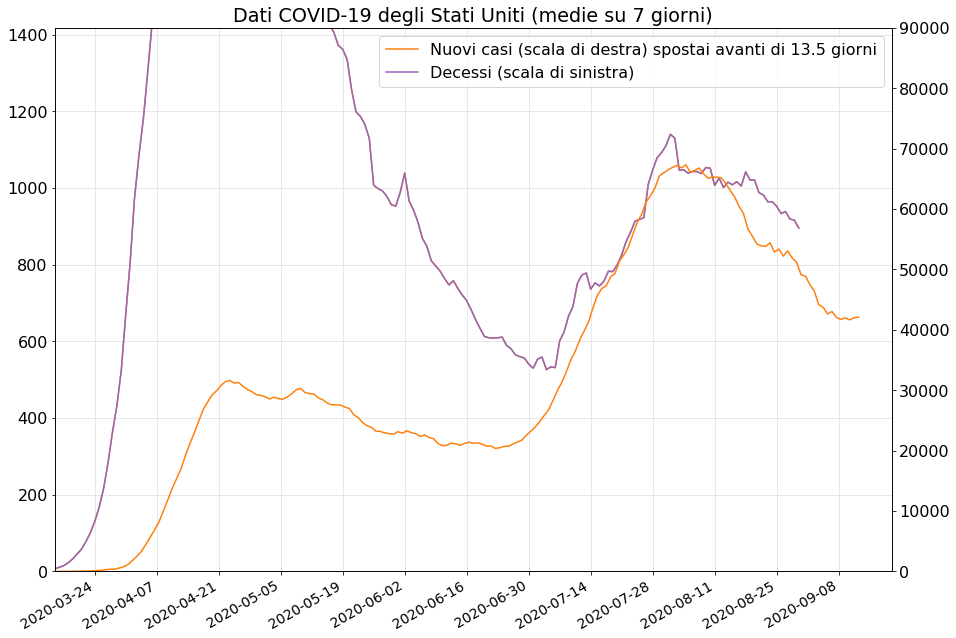

In [139]:
_, ax1 = covid19.plot.subplots(subplot_kw={'xlim': tuple(map(np.datetime64, ('2020-03-15', '2020-09-20')))})
ax2 = ax1.twinx()

usa = ds_states.sum('location')
usa['mortality'] = usa['deaths'] / usa['population'] * 1_000_000
usa['daily_mortality'] = usa['daily_deaths'] / usa['population'] * 1_000_000
usa['daily_mortality7'] = usa['daily_mortality'].rolling({'time': 7}).mean()
usa['daily_deaths7'] = usa['daily_deaths'].rolling({'time': 7}).mean()
usa['daily_prevalence'] = usa['daily_confirmed'] / usa['population'] * 1_000_000
usa['daily_prevalence7'] = usa['daily_prevalence'].rolling({'time': 7}).mean()
usa['daily_confirmed7'] = usa['daily_confirmed'].rolling({'time': 7}).mean()


covid19.plot.plot_data(ax2, usa['daily_confirmed7'], delay=13.5, color='tab:orange', marker=None)
covid19.plot.plot_data(ax1, usa['daily_deaths7'], label='Nuovi casi (scala di destra) spostai avanti di 13.5 giorni', color='tab:orange', marker=None)
covid19.plot.plot_data(ax1, usa['daily_deaths7'], label='Decessi (scala di sinistra)', color='tab:purple', date_interval=14, marker=None)
# covid19.plot.plot_data(ax2, usa['daily_prevalence7'])
ax1.set(ylim=(0, 90000. * 0.01575), ylabel='', xlabel='') 
ax1.set(title=f'Dati COVID-19 degli Stati Uniti (medie su 7 giorni)', ylabel='')
_ = ax2.set(ylim=(0, 90000.), ylabel='', xlabel='') 
ax1.legend()

In [136]:
usa.to_dataframe().tail(20)

population  deaths  confirmed   mortality  daily_deaths  \
time                                                                  
2020-08-11   339573798  164527    5141208  484.510292        1064.0   
2020-08-12   339573798  166034    5197411  488.948208        1507.0   
2020-08-13   339573798  167110    5248958  492.116886        1076.0   
2020-08-14   339573798  168452    5313252  496.068899        1342.0   
2020-08-15   339573798  169481    5361165  499.099168        1029.0   
2020-08-16   339573798  170052    5403213  500.780687         571.0   
2020-08-17   339573798  170497    5438325  502.091154         445.0   
2020-08-18   339573798  171821    5483388  505.990159        1324.0   
2020-08-19   339573798  173177    5529824  509.983400        1356.0   
2020-08-20   339573798  174255    5573847  513.157968        1078.0   
2020-08-21   339573798  175367    5622470  516.432661        1112.0   
2020-08-22   339573798  176350    5667070  519.327466         983.0   
2020-08-23   339573798  176800    5701645  520.652656         450.0   
2020-08-24   339573798  177245    5739536  521.963123         445.0   
2020-08-25   339573798  178486    5777710  525.617704        1241.0   
2020-08-26   339573798  179708    5821819  529.216333        1222.0   
2020-08-27   339573798  180824    5867785  532.502805        1116.0   
2020-08-28   339573798  181800    5913941  535.376996         976.0   
2020-08-29   339573798  182761    5961094  538.207014         961.0   
2020-08-30   339573798  183066    5996431  539.105199         305.0   

            daily_mortality  daily_mortality7  daily_confirmed  \
time                                                             
2020-08-11         3.133340          2.963799          46808.0   
2020-08-12         4.437916          3.020593          56203.0   
2020-08-13         3.168678          2.947392          51547.0   
2020-08-14         3.952013          2.989041          64294.0   
2020-08-15         3.030269          2.969268          47913.0   
2020-08-16         1.681520          2.992827          42048.0   
2020-08-17         1.310466          2.959172          35112.0   
2020-08-18         3.899005          3.068552          45063.0   
2020-08-19         3.993241          3.005027          46436.0   
2020-08-20         3.174568          3.005869          44023.0   
2020-08-21         3.274693          2.909109          48623.0   
2020-08-22         2.894805          2.889757          44600.0   
2020-08-23         1.325191          2.838853          34575.0   
2020-08-24         1.310466          2.838853          37891.0   
2020-08-25         3.654581          2.803935          38174.0   
2020-08-26         3.598629          2.747562          44109.0   
2020-08-27         3.286473          2.763548          45966.0   
2020-08-28         2.874191          2.706334          46156.0   
2020-08-29         2.830018          2.697078          47153.0   
2020-08-30         0.898185          2.636078          35337.0   

            daily_prevalence  daily_prevalence7  daily_deaths7  \
time                                                             
2020-08-11        137.843380         155.711156    1006.428571   
2020-08-12        165.510414         157.138575    1025.714286   
2020-08-13        151.799109         153.712011    1000.857143   
2020-08-14        189.337341         156.287088    1015.000000   
2020-08-15        141.097459         152.811723    1008.285714   
2020-08-16        123.825808         150.755784    1016.285714   
2020-08-17        103.400204         144.687674    1004.857143   
2020-08-18        132.704585         143.953560    1042.000000   
2020-08-19        136.747889         139.844628    1020.428571   
2020-08-20        129.641922         136.679316    1020.714286   
2020-08-21        143.188315         130.086598     987.857143   
2020-08-22        131.341111         128.692834     981.285714   
2020-08-23        101.818810         125.548977     964.000000   
2020-0

In [137]:
STATES_FIT_PARAMS = {
    'US / New York': {
        'deaths': ['2020-03-22', '2020-04-04'],
    },
    'US / New Jersey': {
        'deaths': [None, '2020-04-05', '2020-04-05'],
    },
    'US / Connecticut': {
        'deaths': [None, '2020-04-08'],
    },
    'US / Massachusetts': {
        'deaths': [None, '2020-04-07'],
    },
    'US / Louisiana': {
        'deaths': [None, '2020-04-01'],
    },
    'US / District of Columbia': {
        'deaths': [None, '2020-04-01'],
    },
    'US / Michigan': {
        'deaths': ['2020-03-25', '2020-04-02', None],
    },
    'US / Rhode Island': {
        'deaths': [None, '2020-04-08'],
    },
    'US / Pennsylvania': {
        'deaths': [None, '2020-04-08'],
    },
    'US / Maryland': {
        'deaths': [None, None],
    },
    'US / Illinois': {
        'deaths': [None, '2020-04-10'],
    },
    'US / Indiana': {
        'deaths': [None, '2020-04-08'],
    },
    'US / Colorado': {
        'deaths': [None, None],
    },
    'US / Washington': {
        'deaths': [None, '2020-03-26', '2020-04-10'],
    },
    'US / Georgia': {
        'deaths': [None, '2020-04-10'],
    },
    'US / California': {
        'deaths': [None, '2020-03-26', None],
    },
    'US / Florida': {
        'deaths': [None, None],
    },
    'US / Delaware': {
        'deaths': [None, None],
    },
    'US / Nebraska': {
        'deaths': [None, None],
    },
}

In [138]:
region_fits = {}
for region, params in list(STATES_FIT_PARAMS.items()):
    region_fits[region] = {}
    for kind, breaks in params.items():
        ds = ds_states.sel(location=region)
        region_fits[region][kind] = covid19.fit.fit_exponential_segments(ds[kind], breaks)
        if 'daily_' + kind in ds:
            kinf = 'daily_' + kind 
            region_fits[region][kind] = covid19.fit.fit_exponential_segments(ds[kind], breaks)


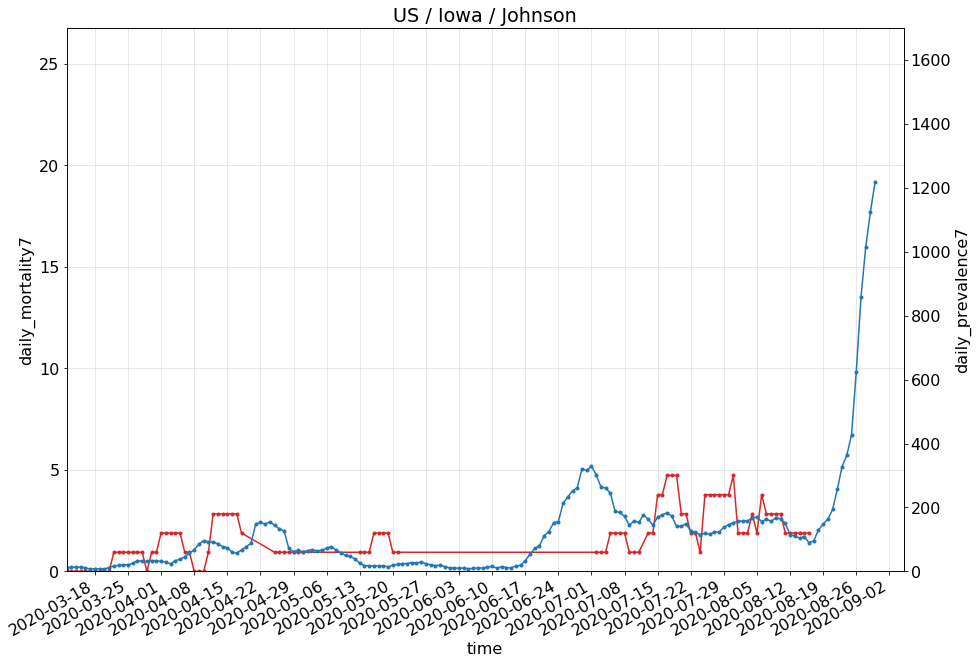

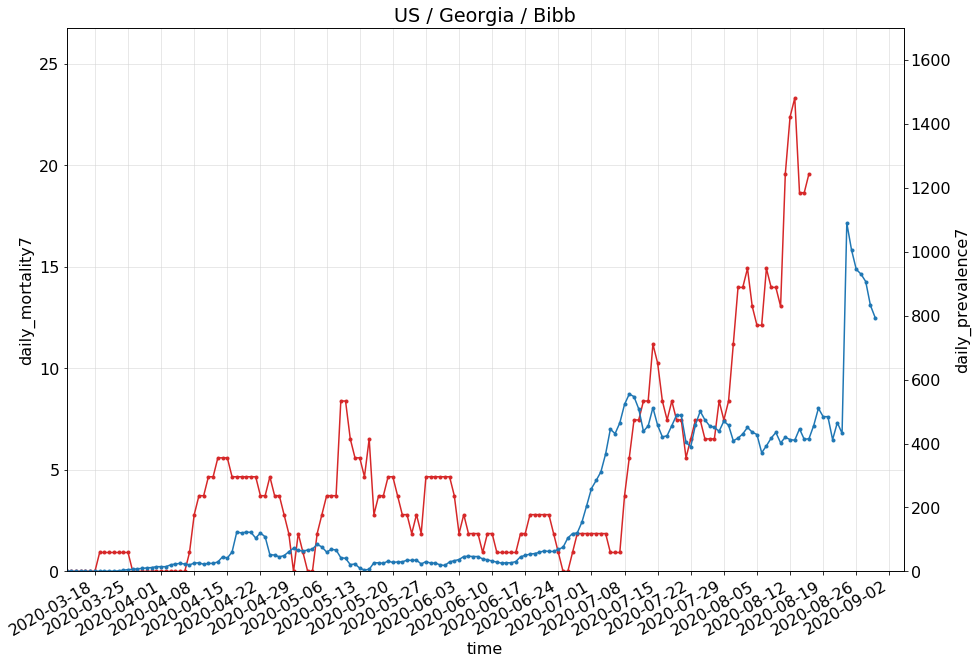

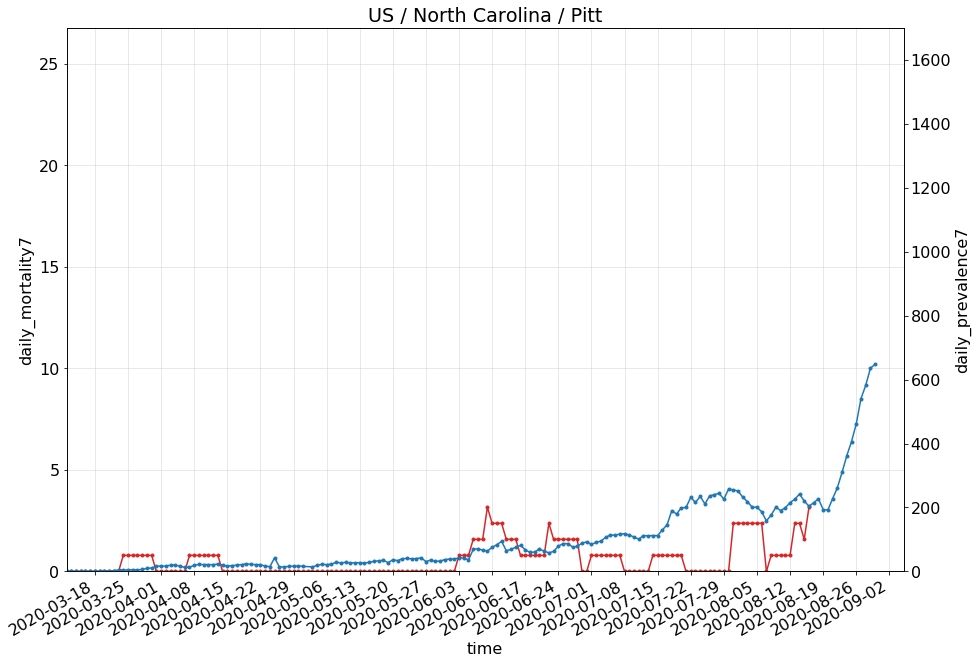

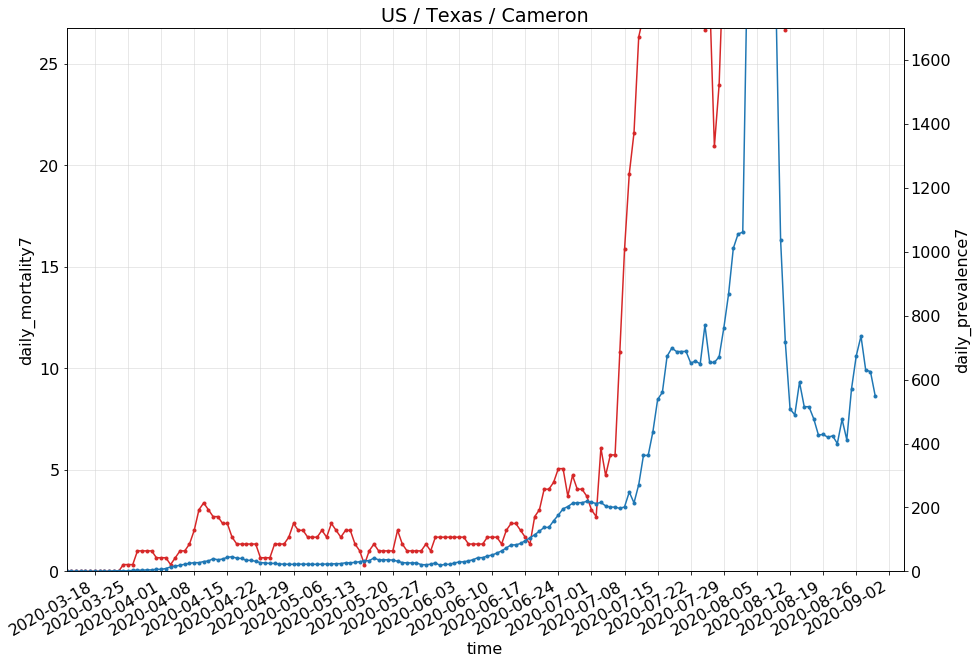

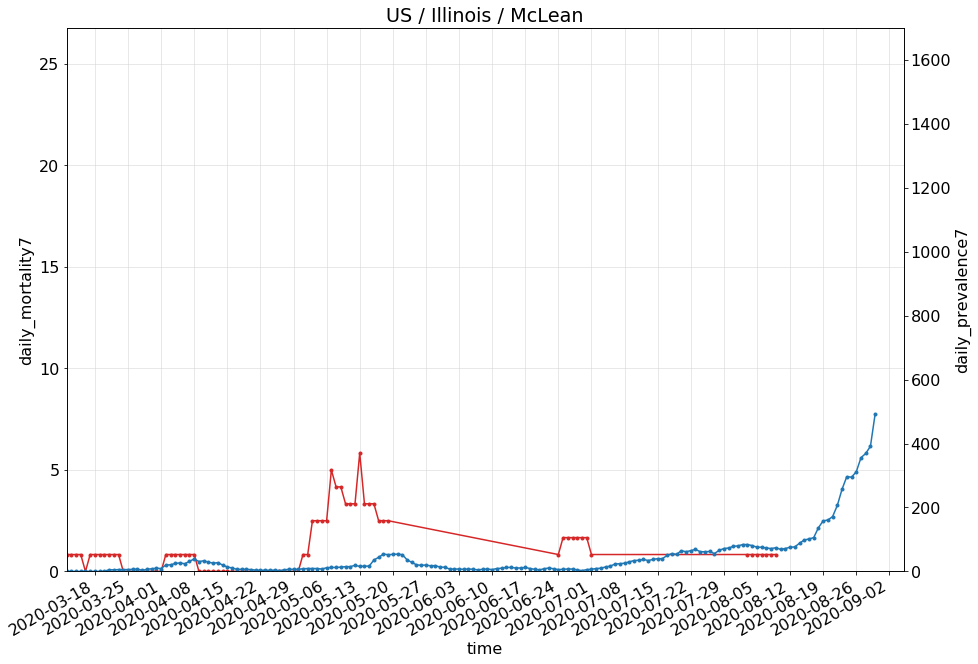

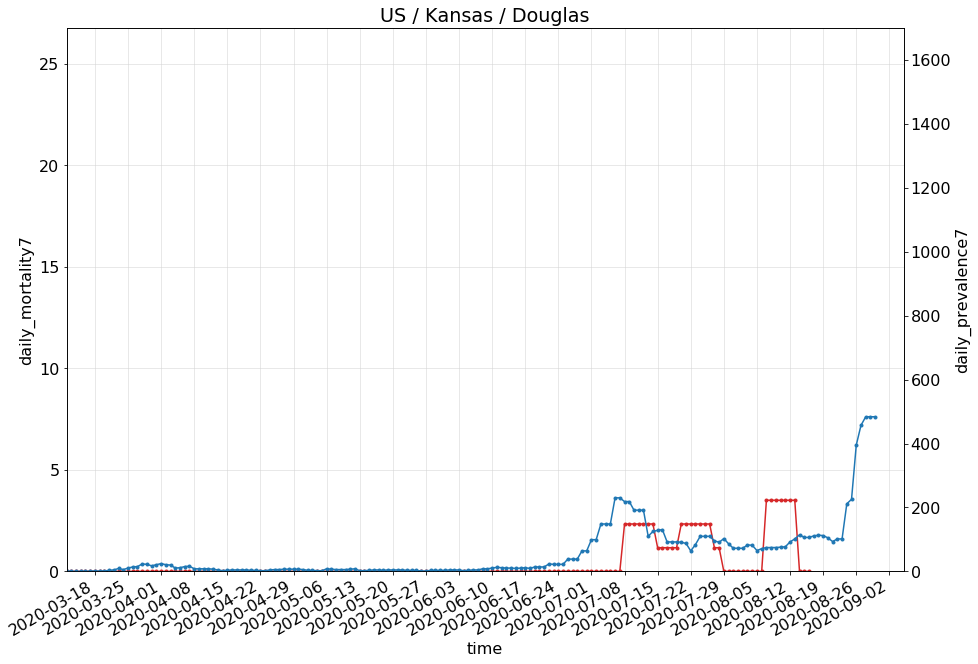

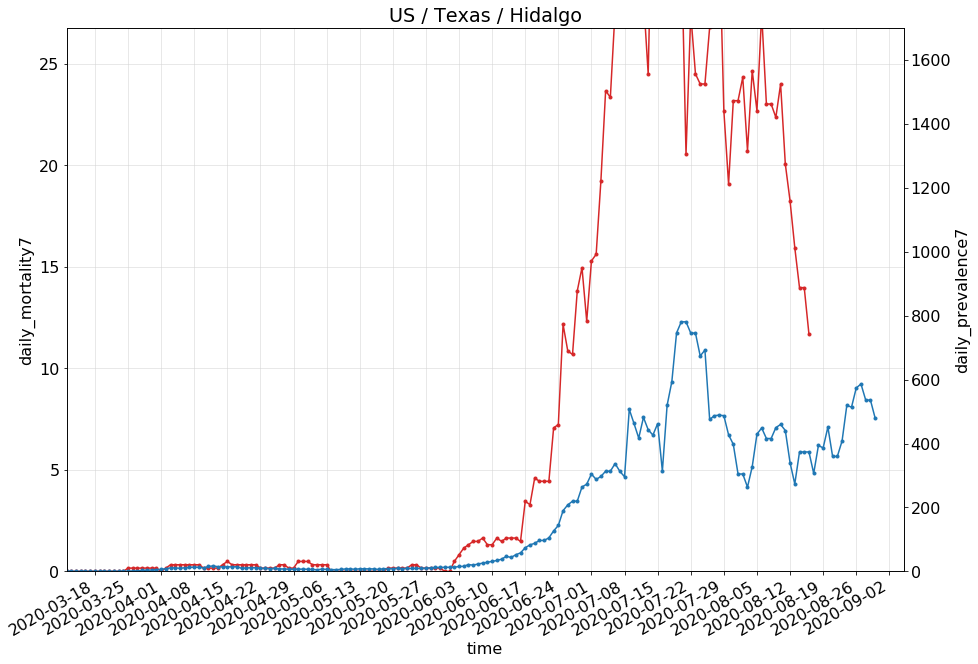

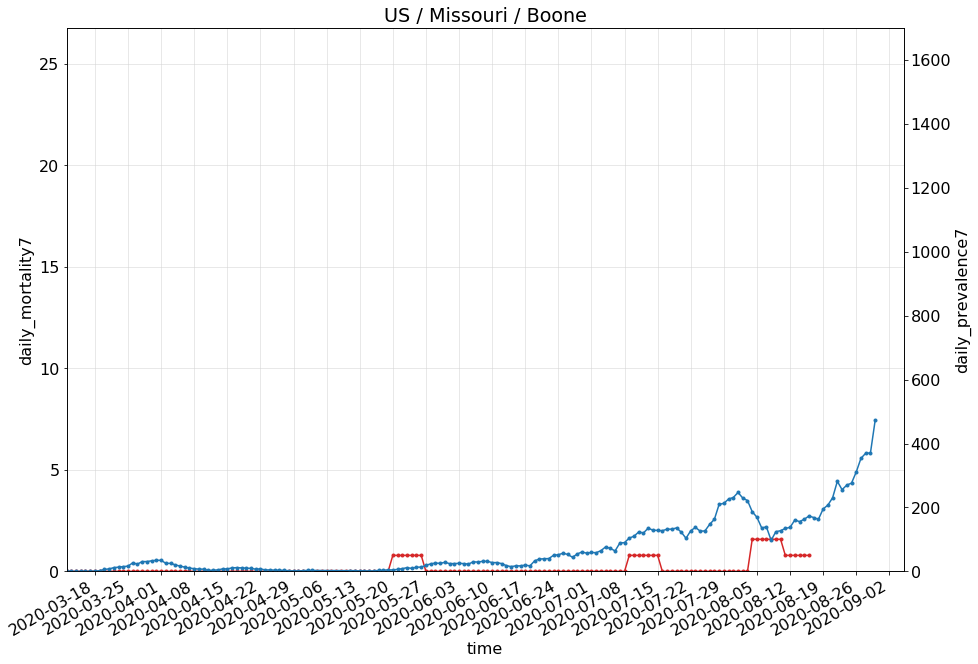

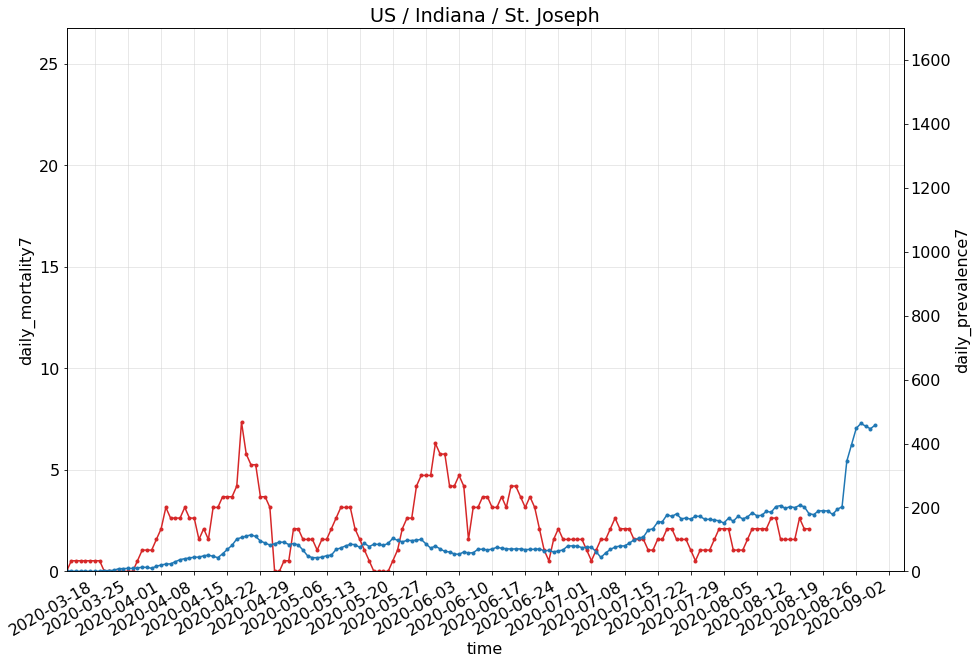

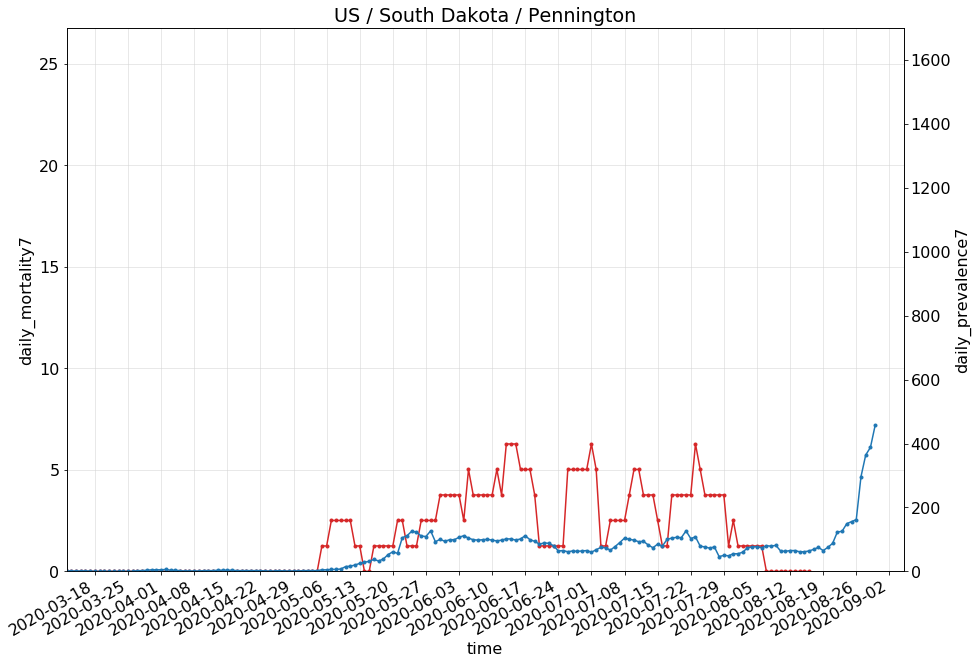

In [133]:
tmp = ds_counties.sortby(-ds_counties['daily_prevalence7'].isel(time=-1))
for location in list(tmp.sel(location=tmp['population'] > 100_000).location.values)[:10]:
    _, ax1 = plt.subplots(subplot_kw={'xlim': XLIM})

    ax1.yaxis.tick_right()
    ax1.yaxis.grid(color='lightgrey', linewidth=0.5)
    ax1.xaxis.grid(color='lightgrey', linewidth=0.5)

    ds = ds_counties.sel(location=location)

    ax2 = ax1.twinx()
    
    covid19.plot.plot_data(ax1, ds['daily_mortality7'], color=PALETTE_ONE[3], delay=-14)
    covid19.plot.plot_data(ax2, ds['daily_prevalence7'], color=PALETTE_ONE[0])

    ax1.set(ylim=(0, 1700. * 0.01575), title=location)
    ax2.set(ylim=(0, 1700.), title=None)

ImportError: Plotting of arrays of cftime.datetime objects or arrays indexed by cftime.datetime objects requires the optional `nc-time-axis` (v1.2.0 or later) package.

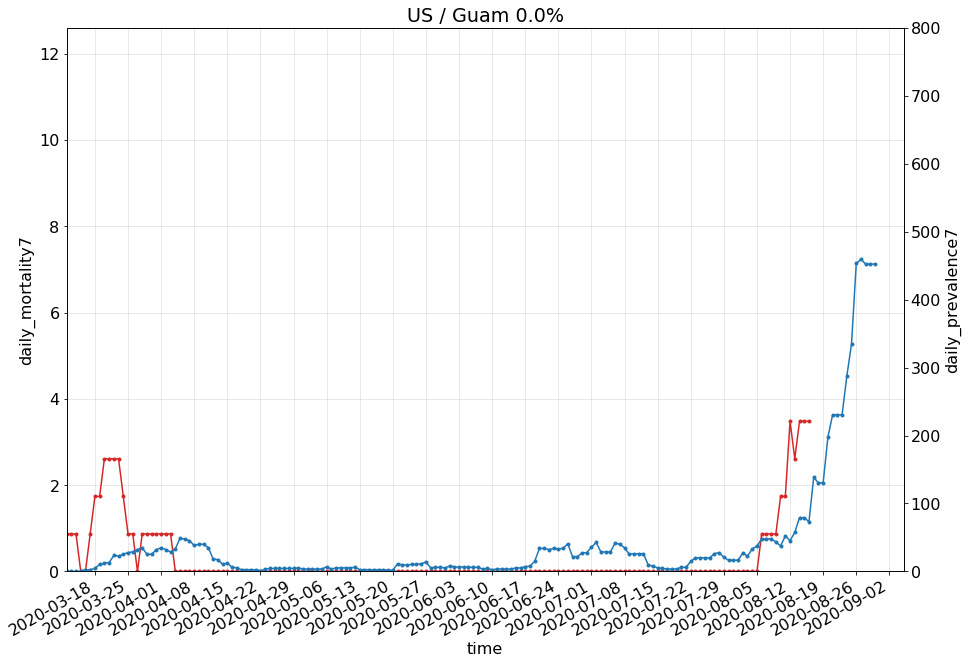

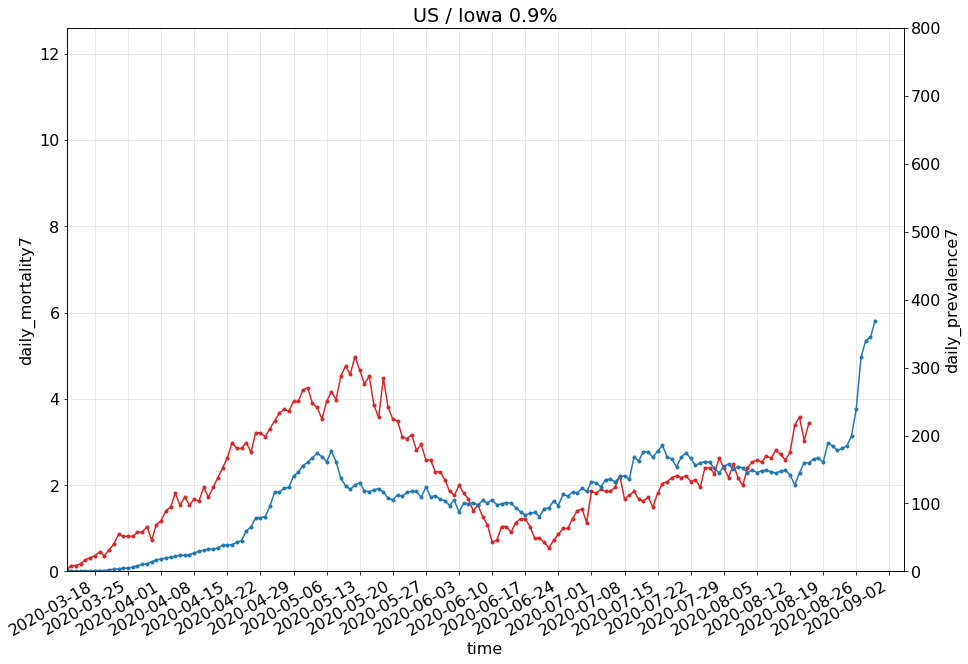

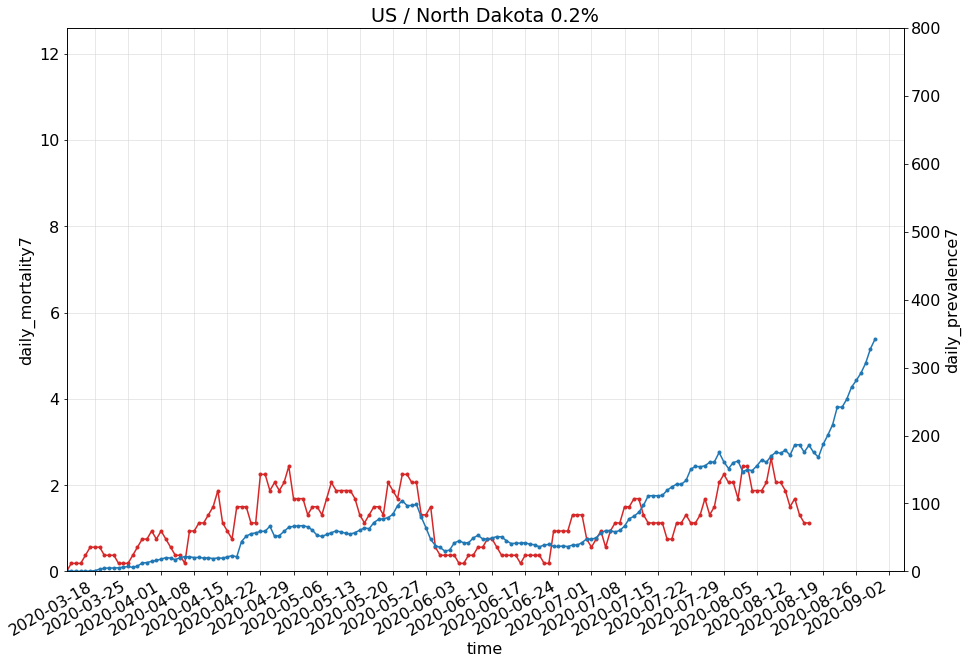

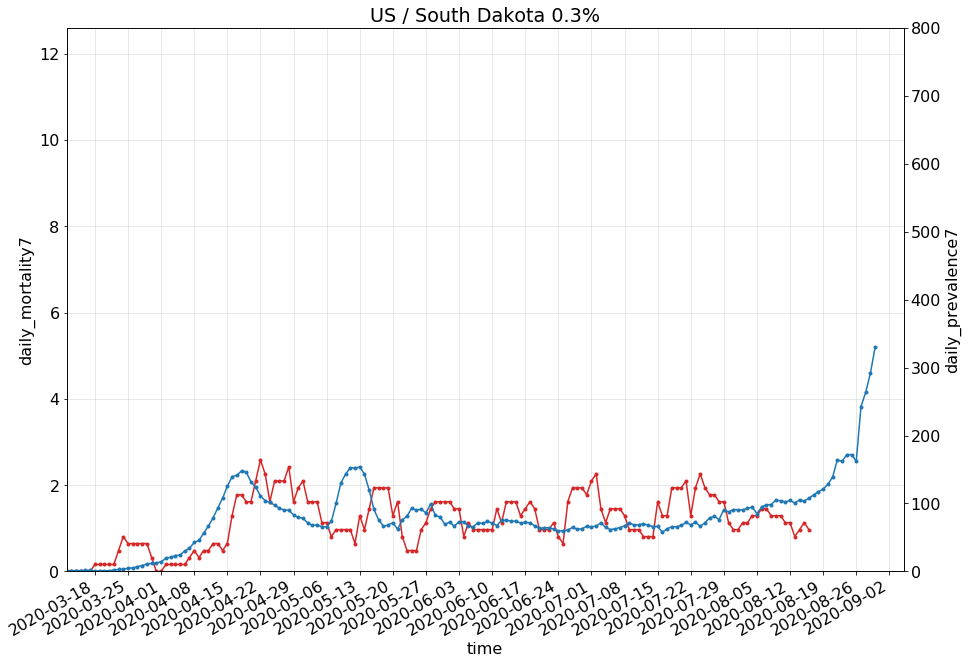

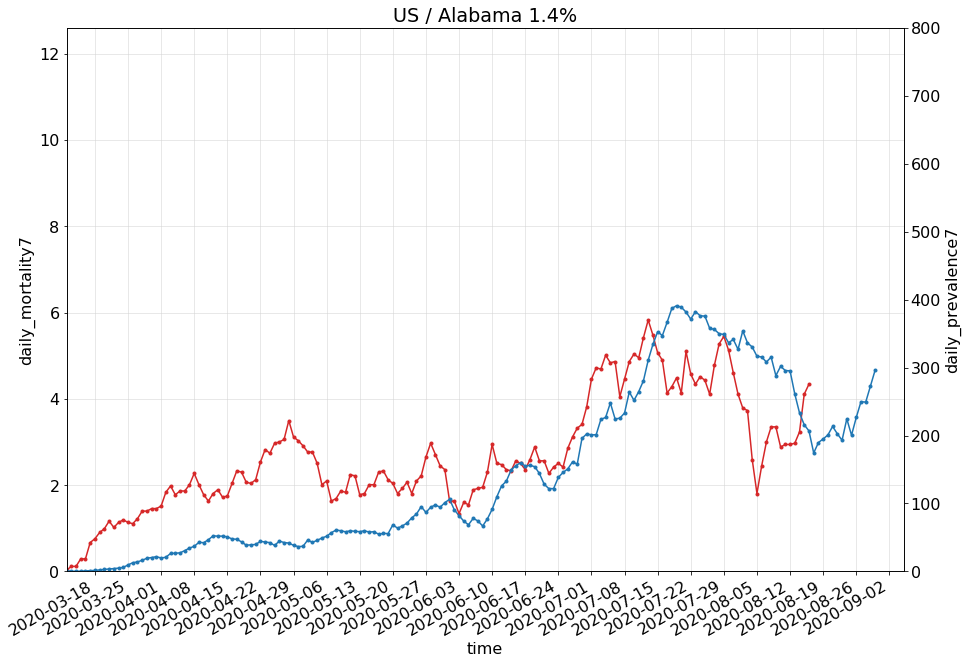

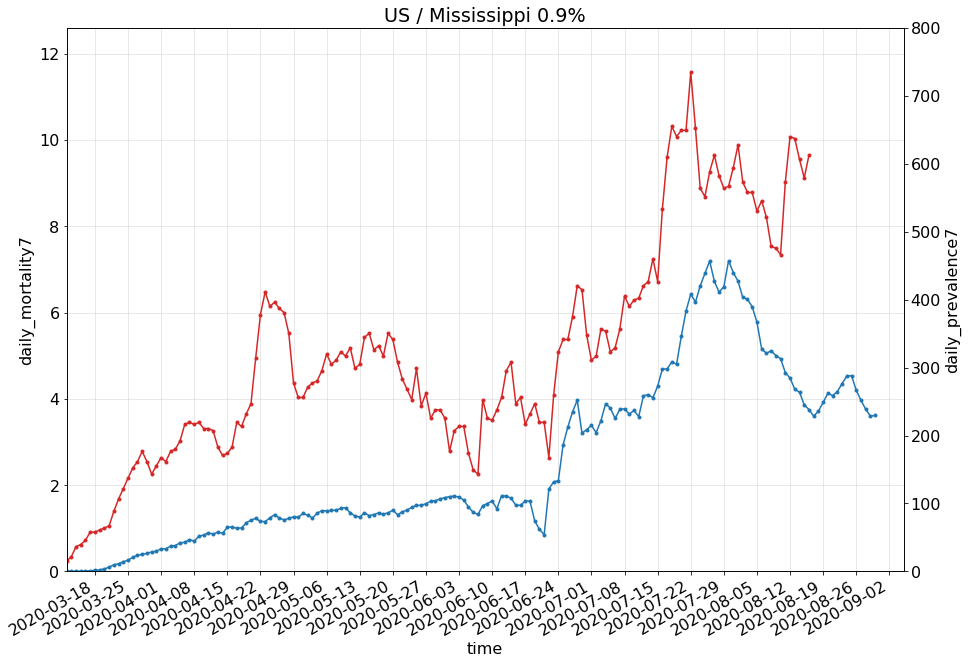

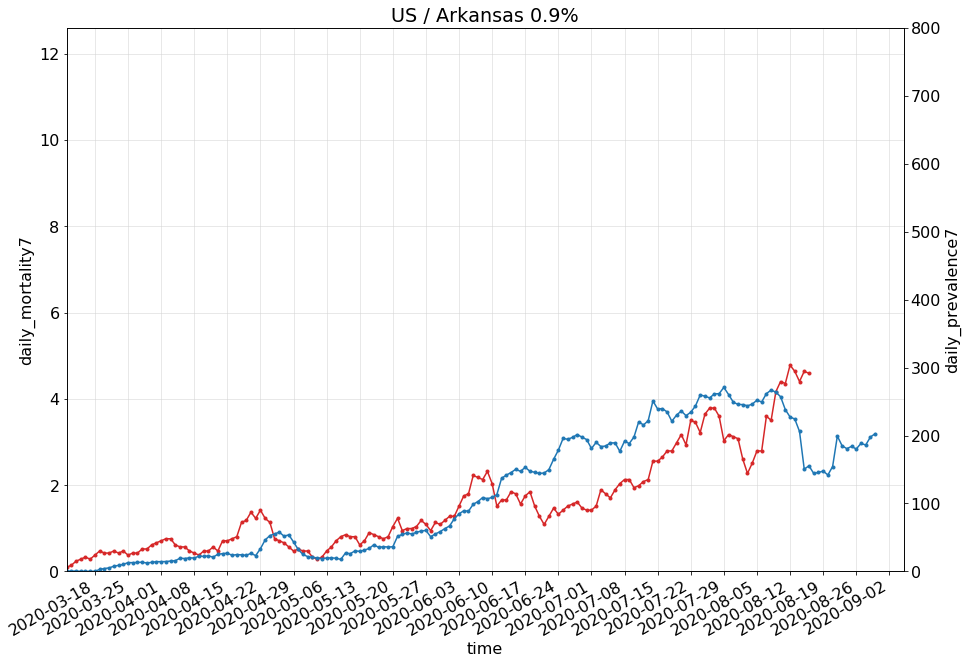

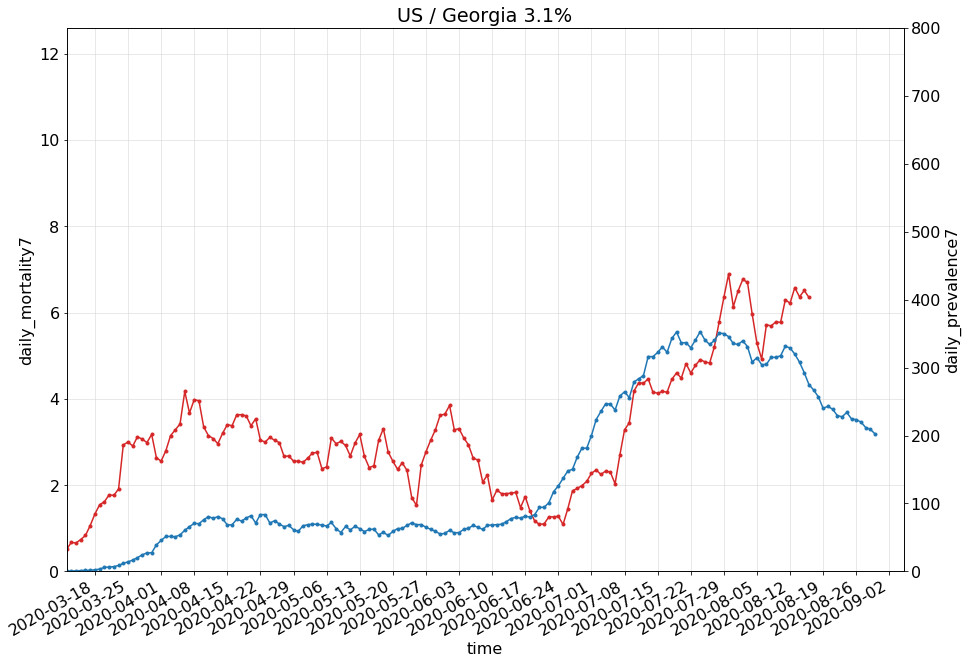

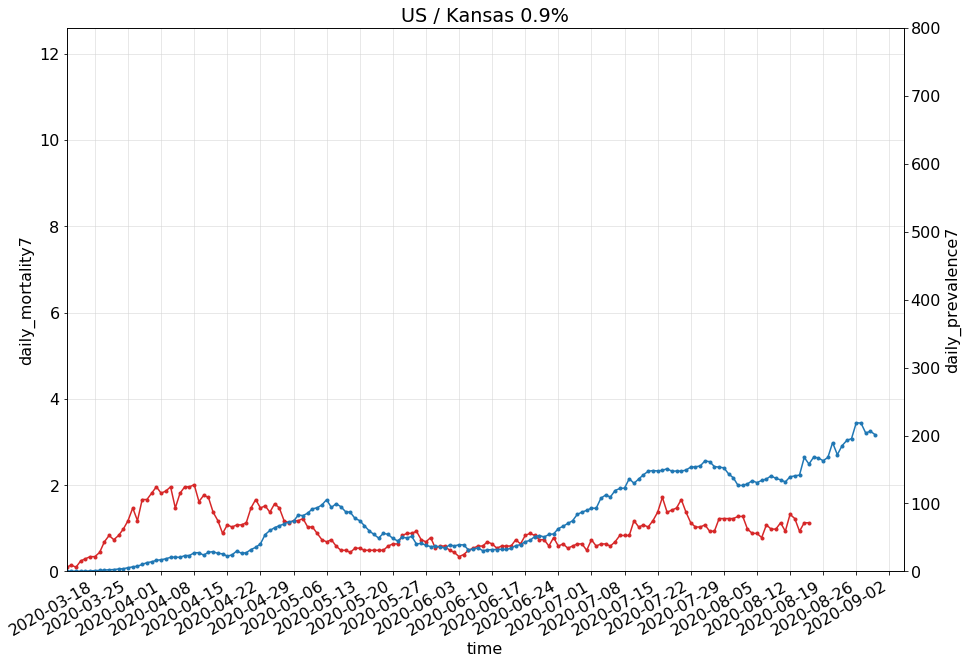

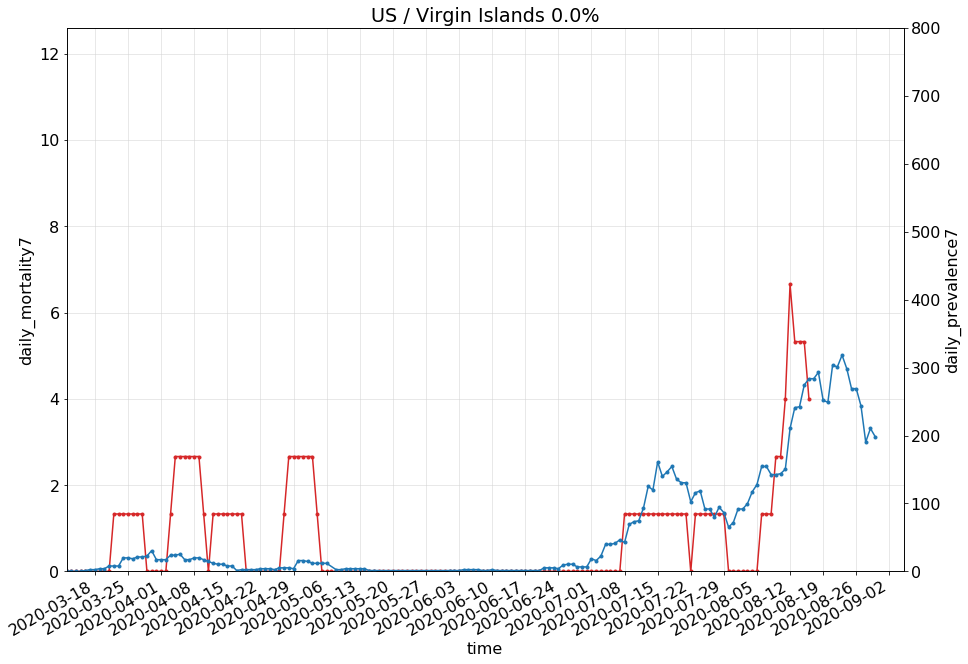

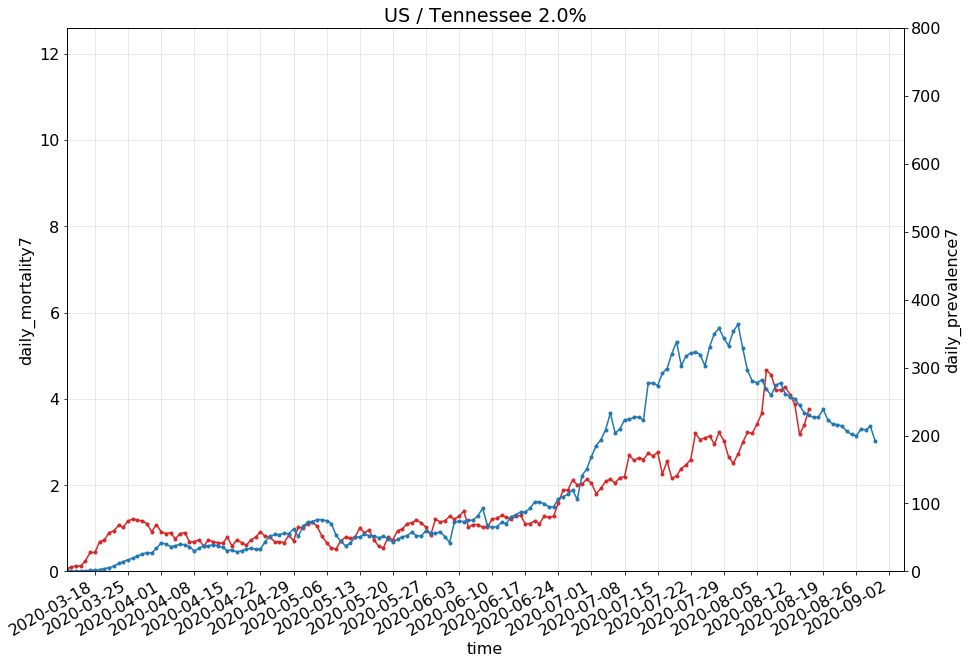

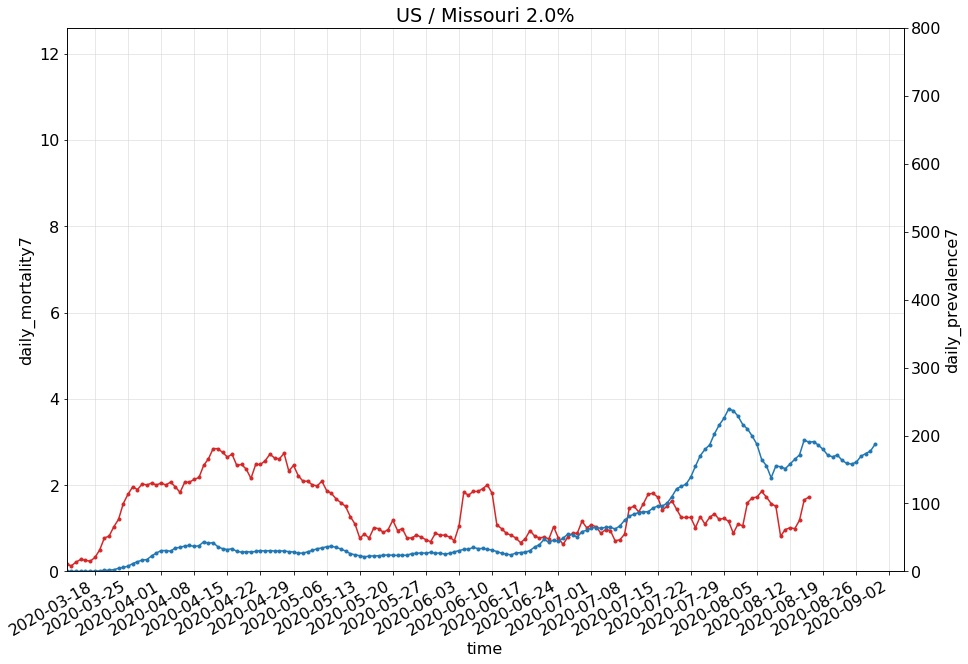

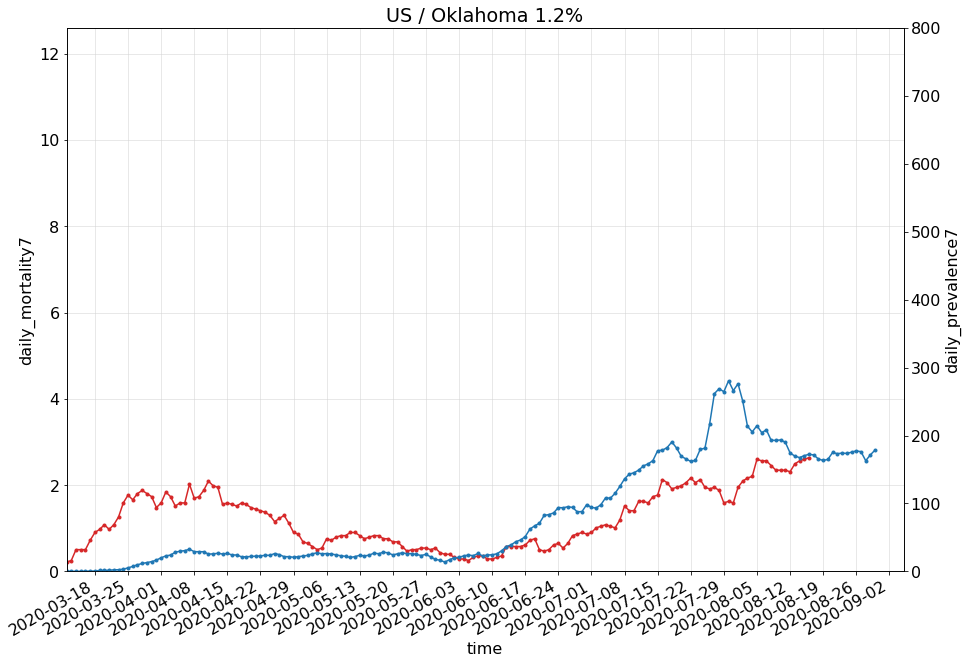

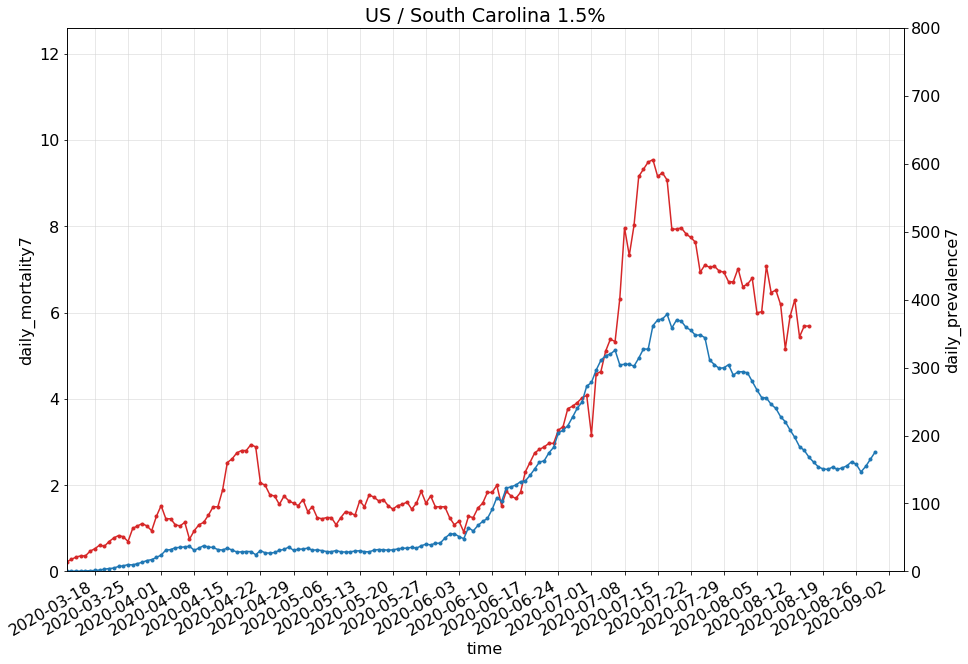

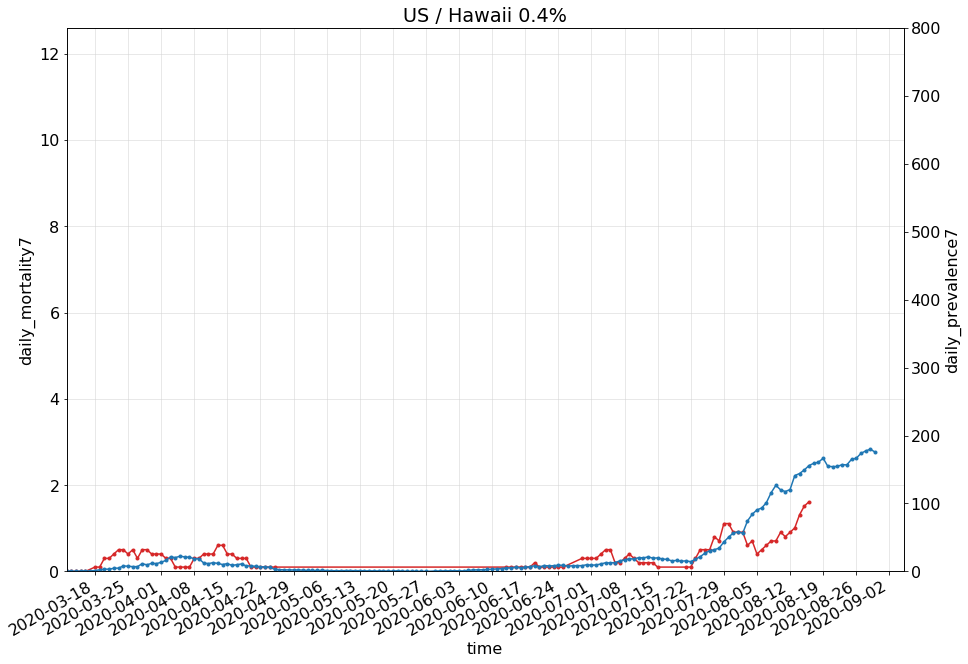

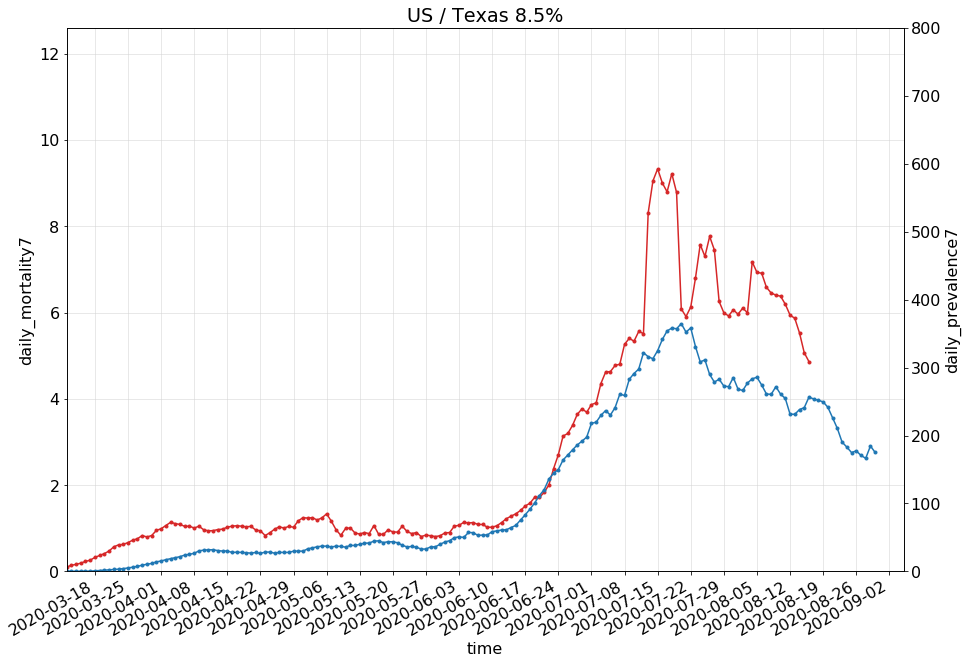

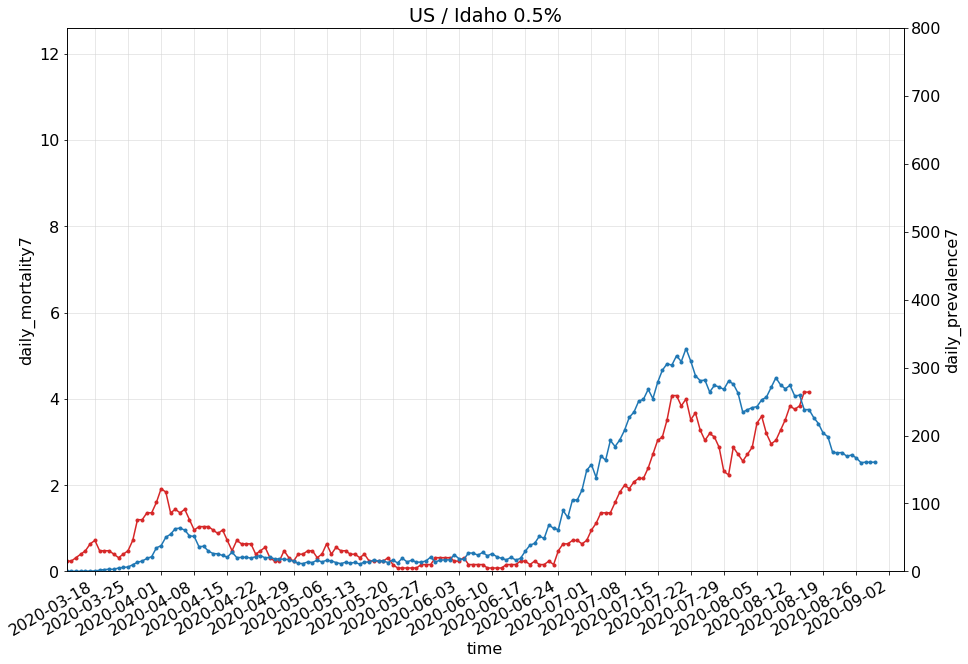

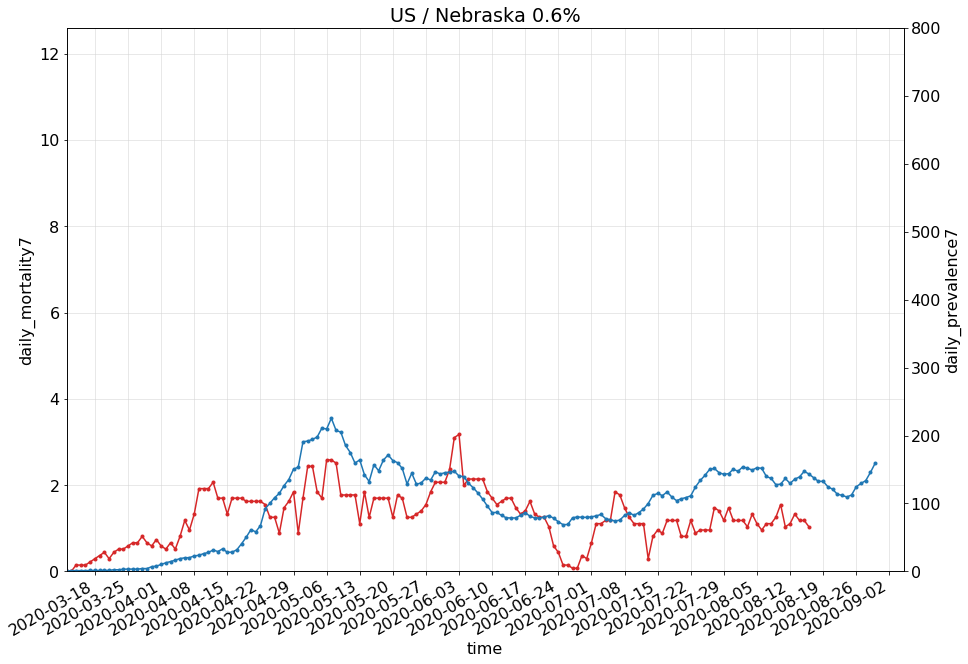

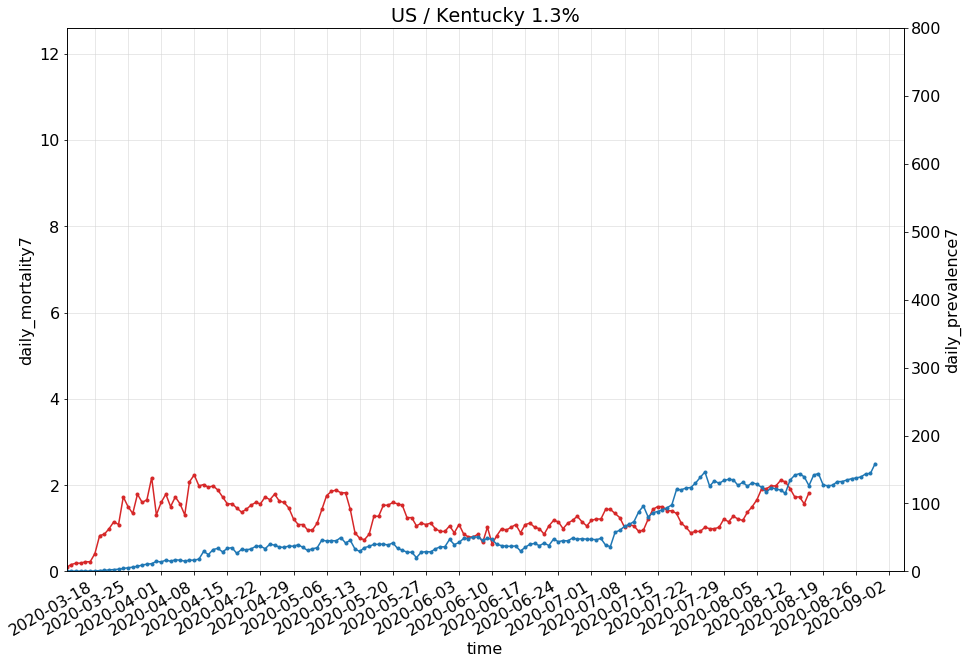

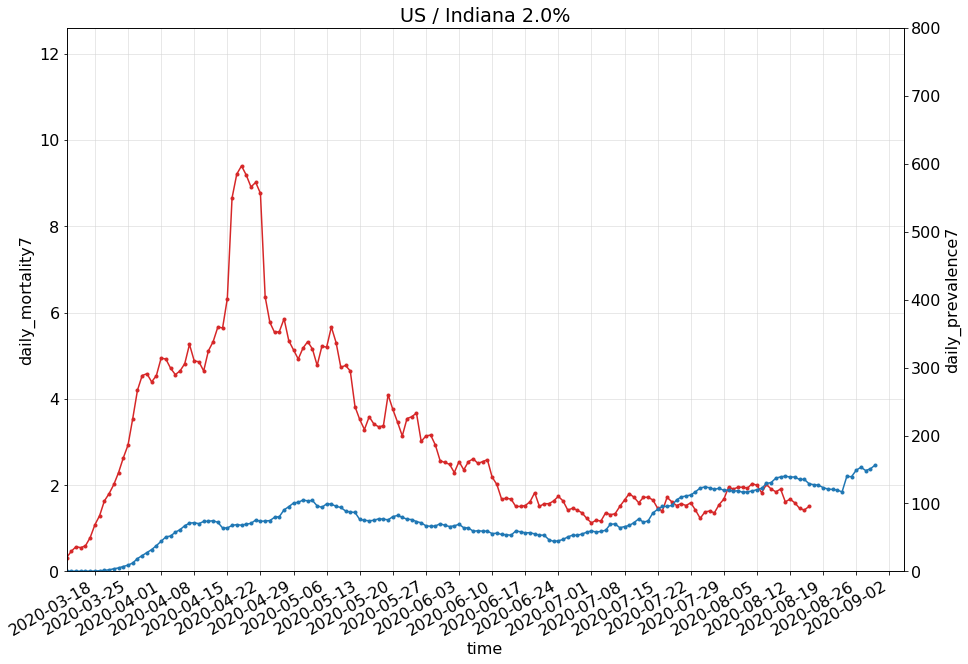

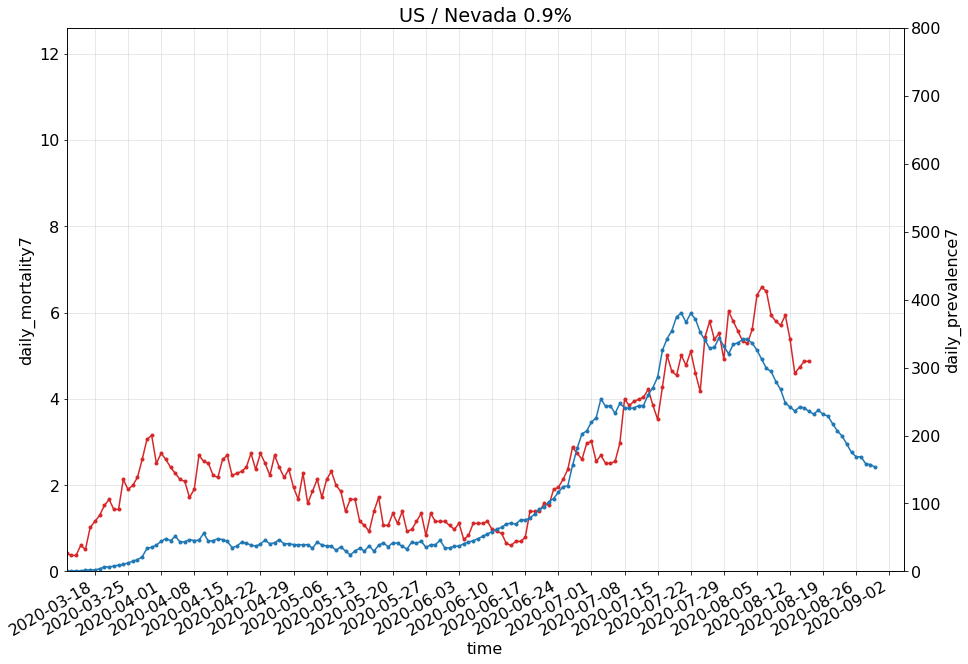

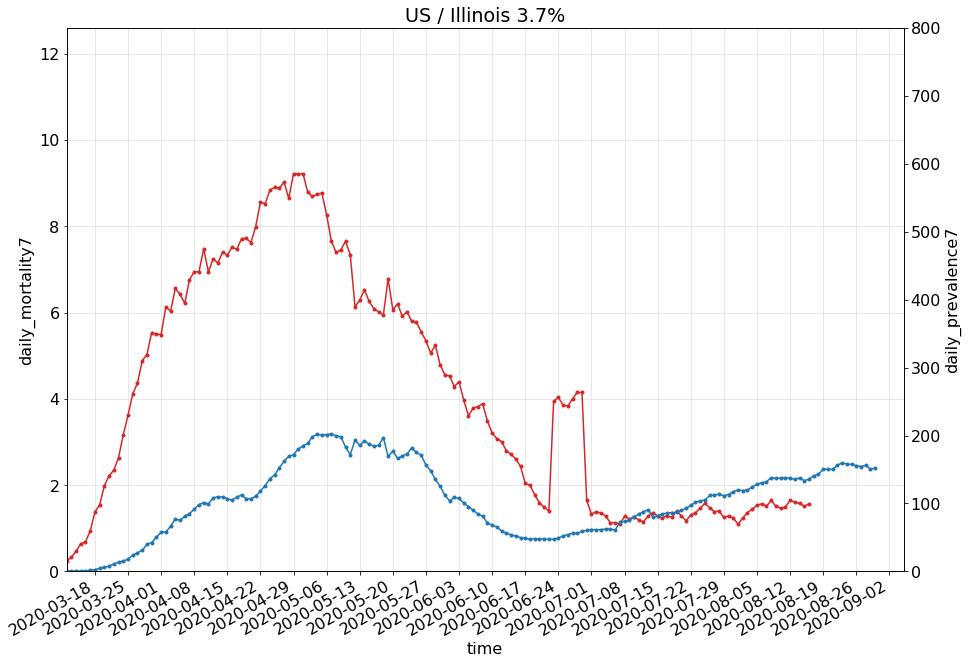

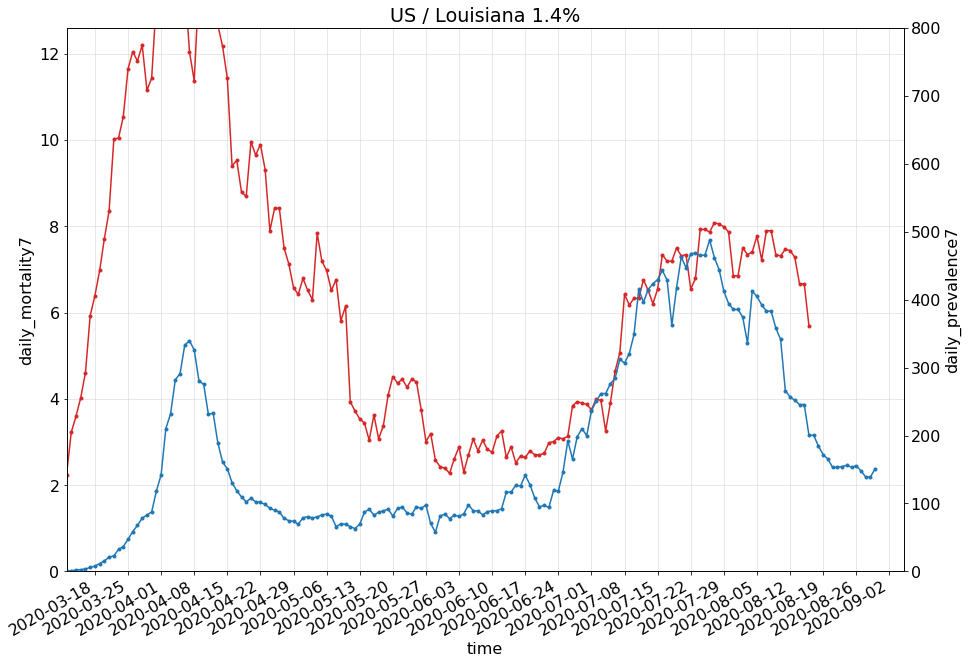

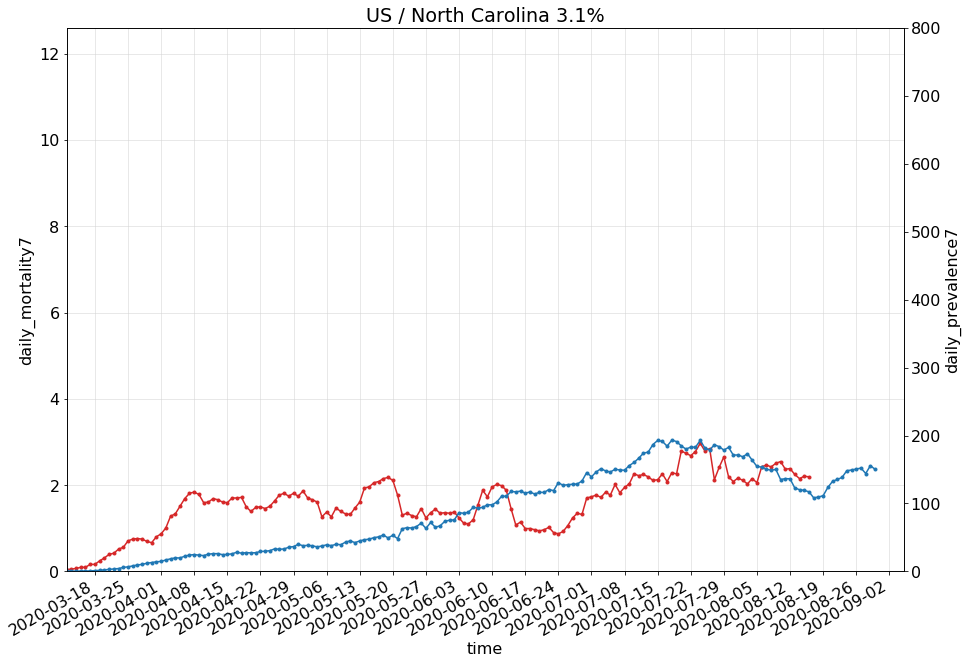

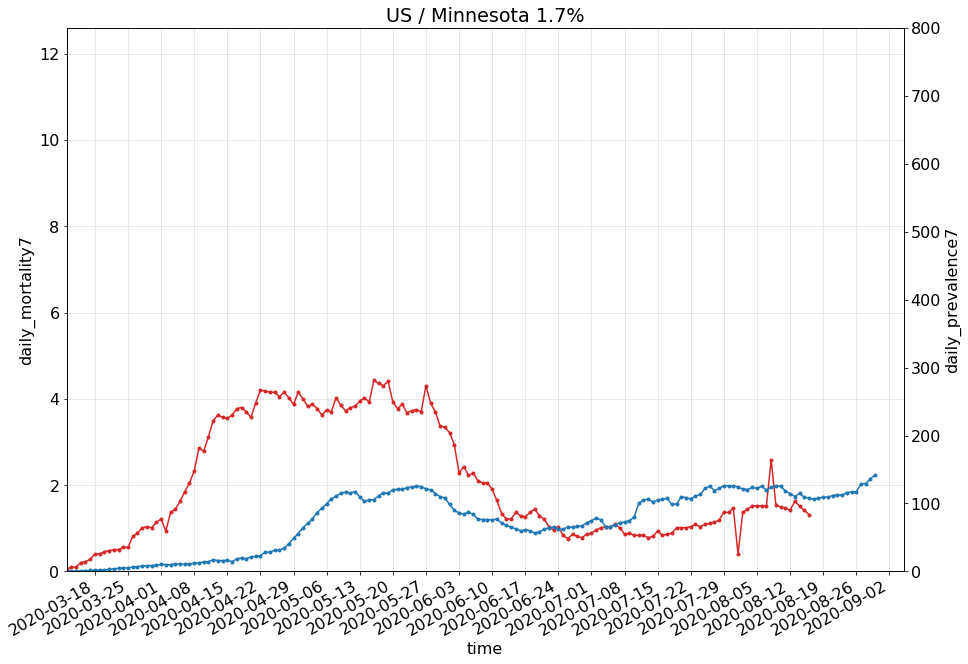

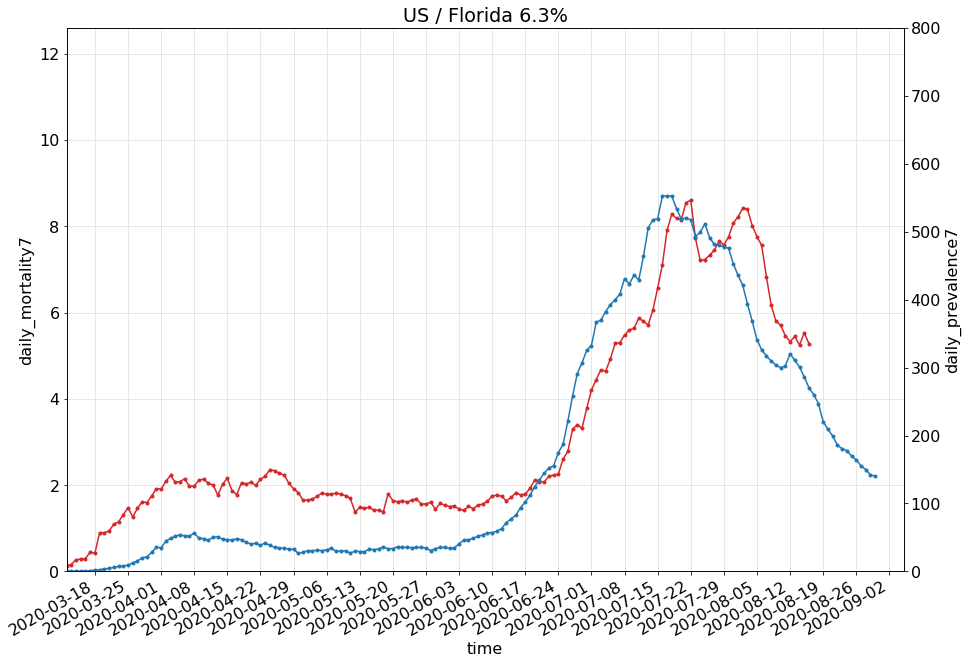

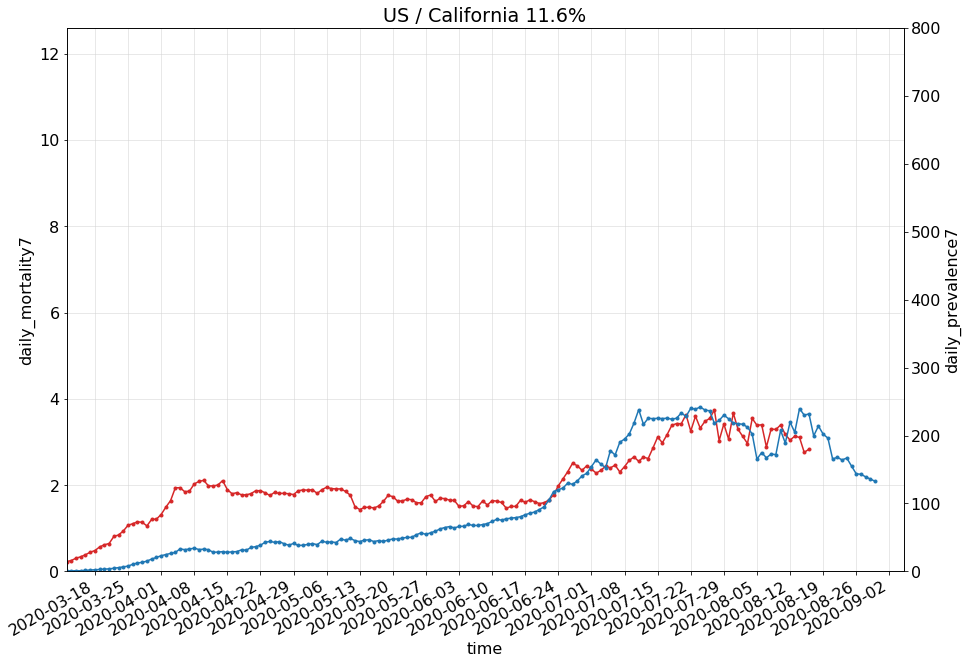

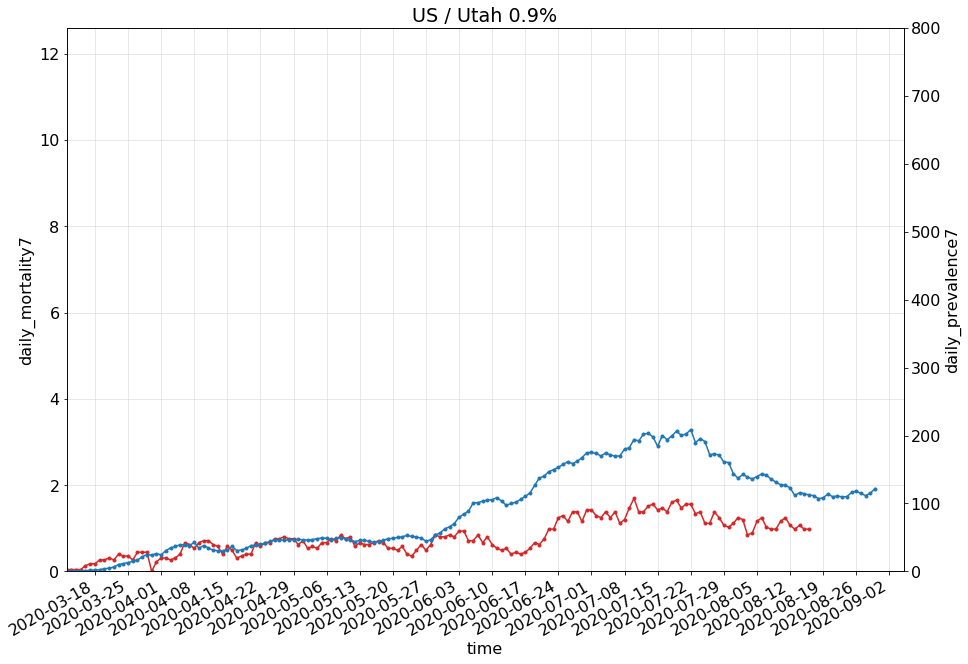

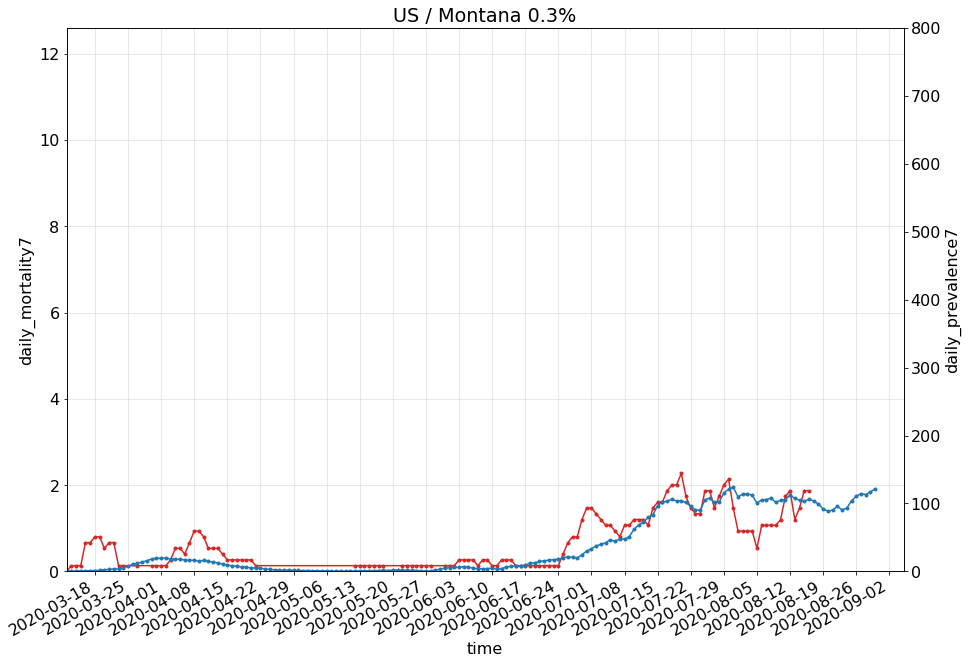

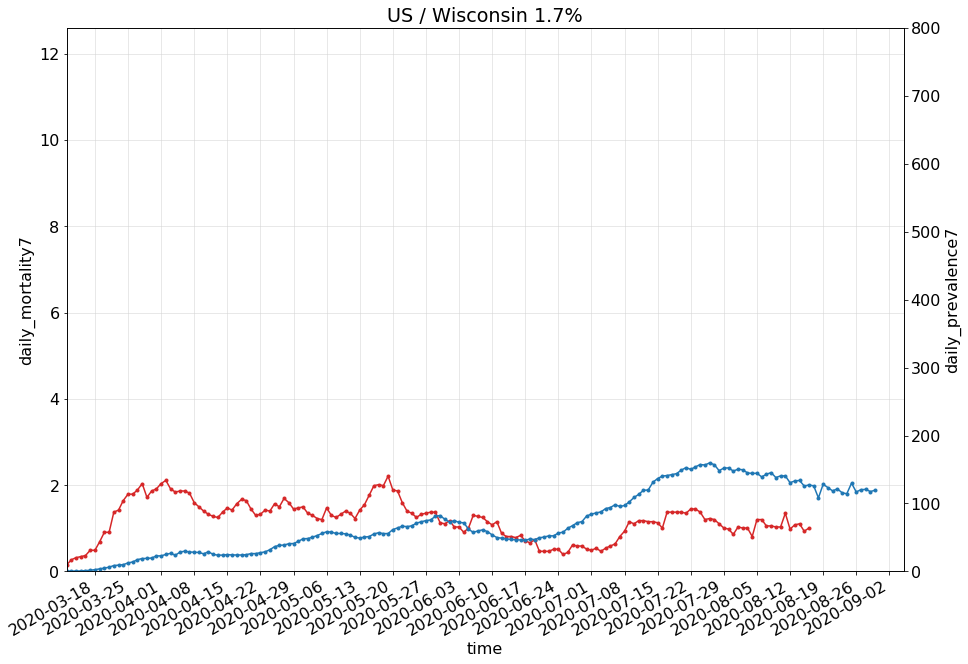

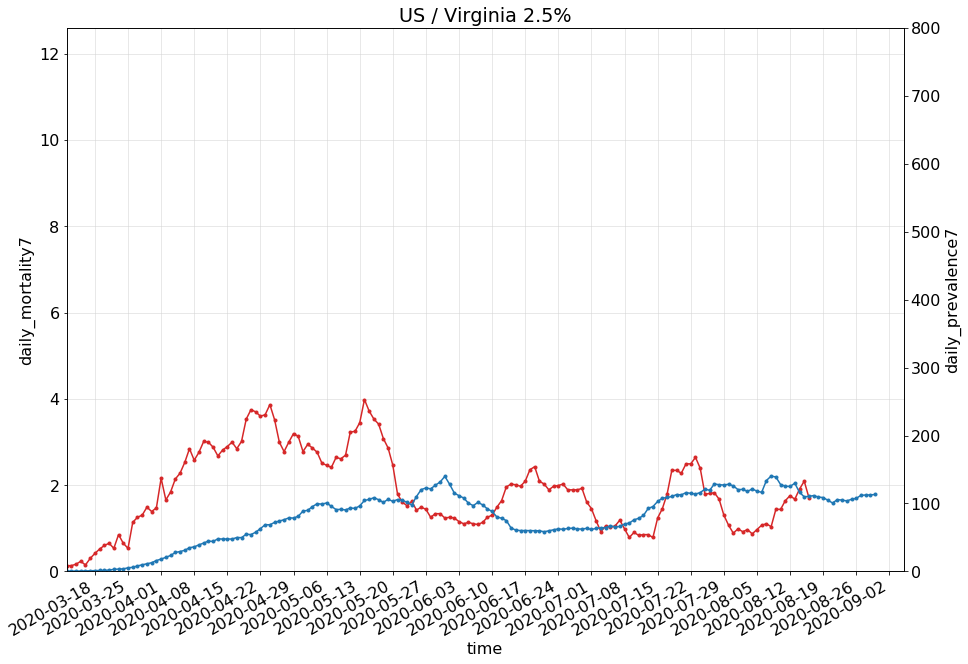

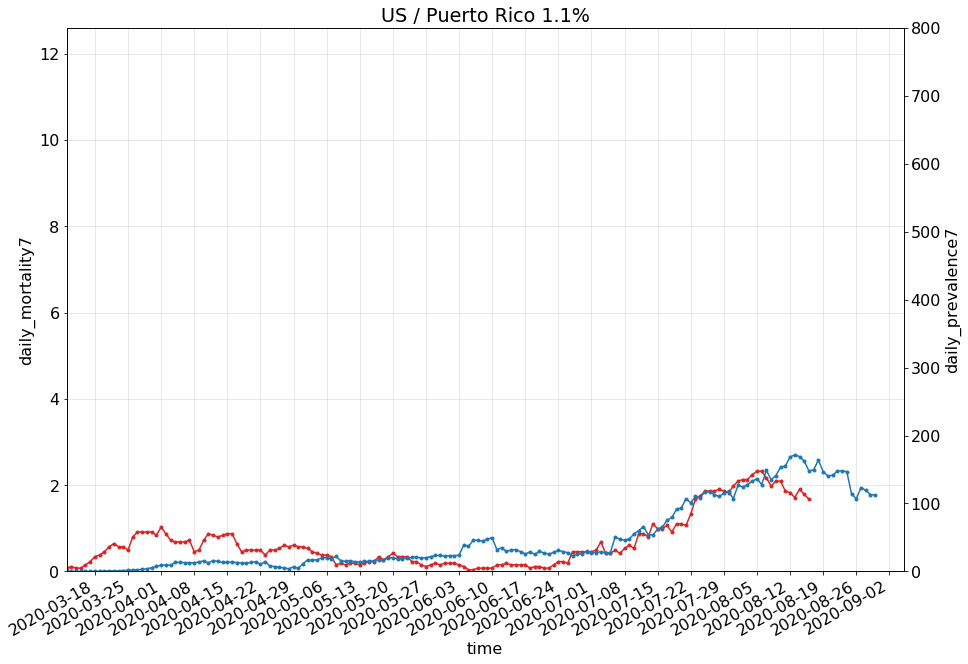

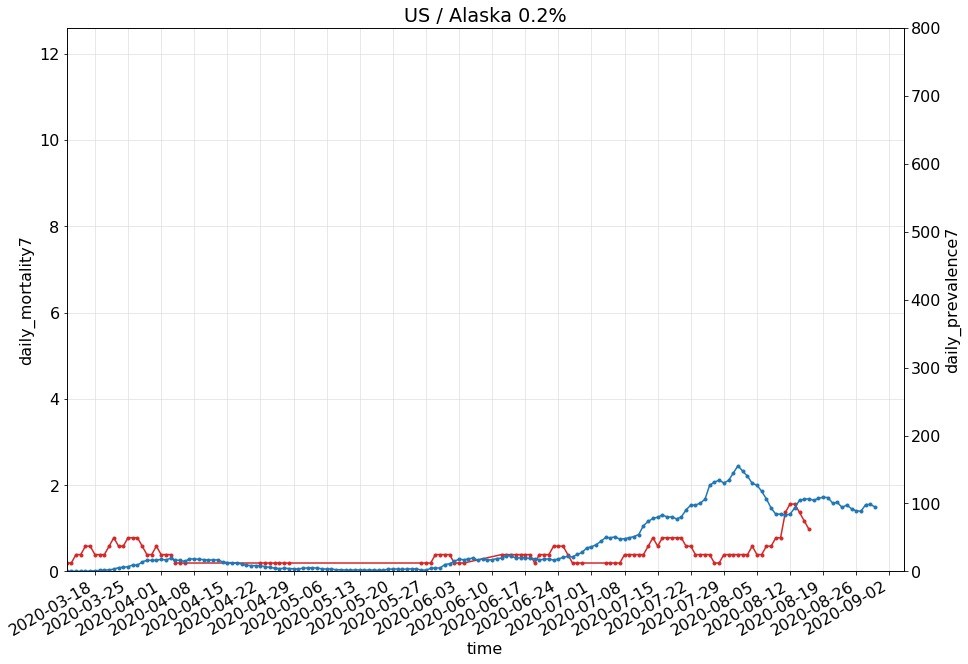

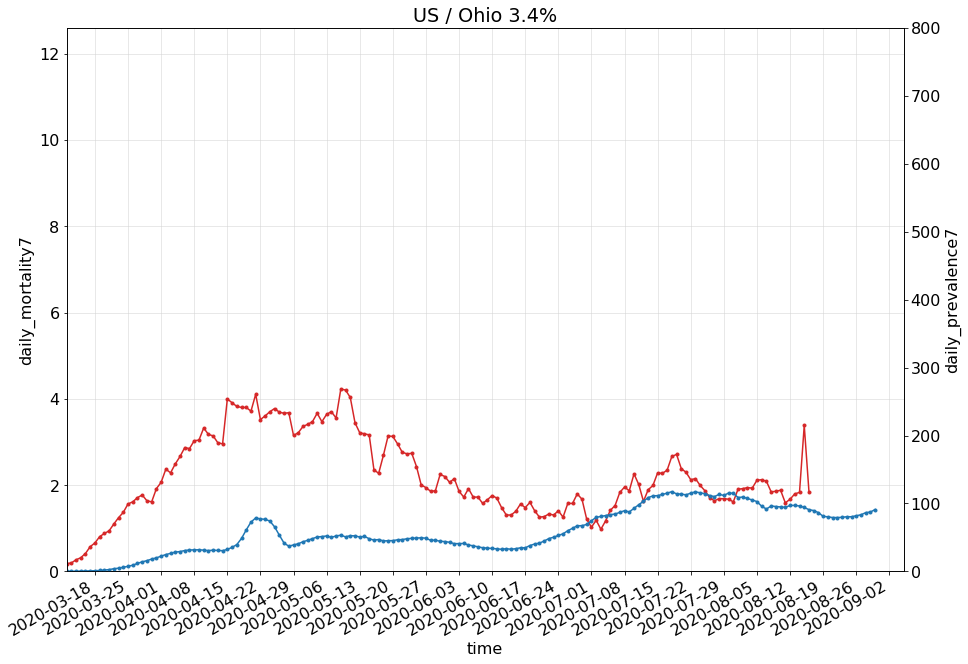

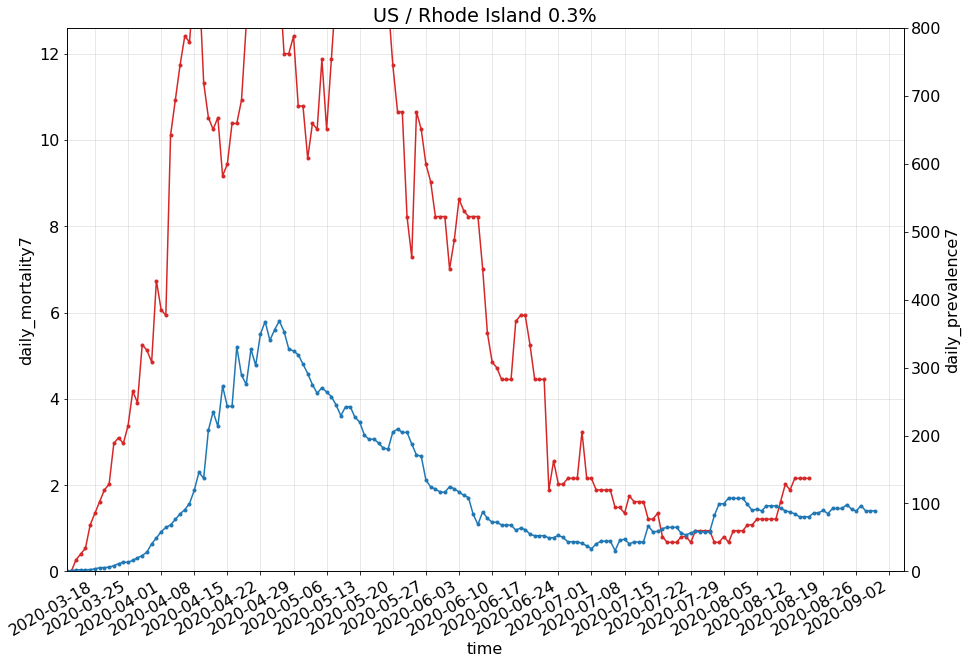

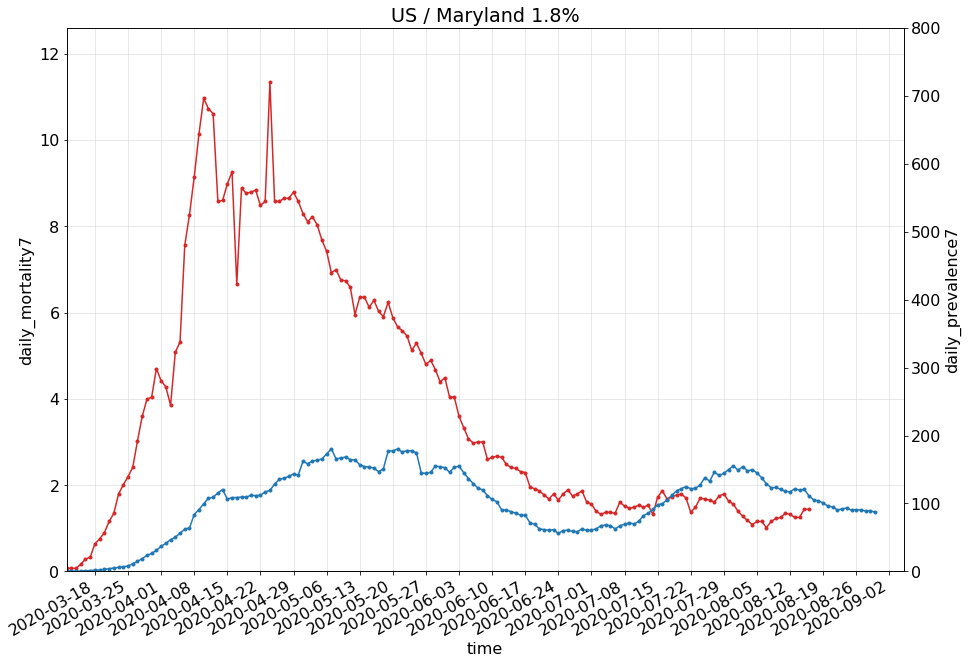

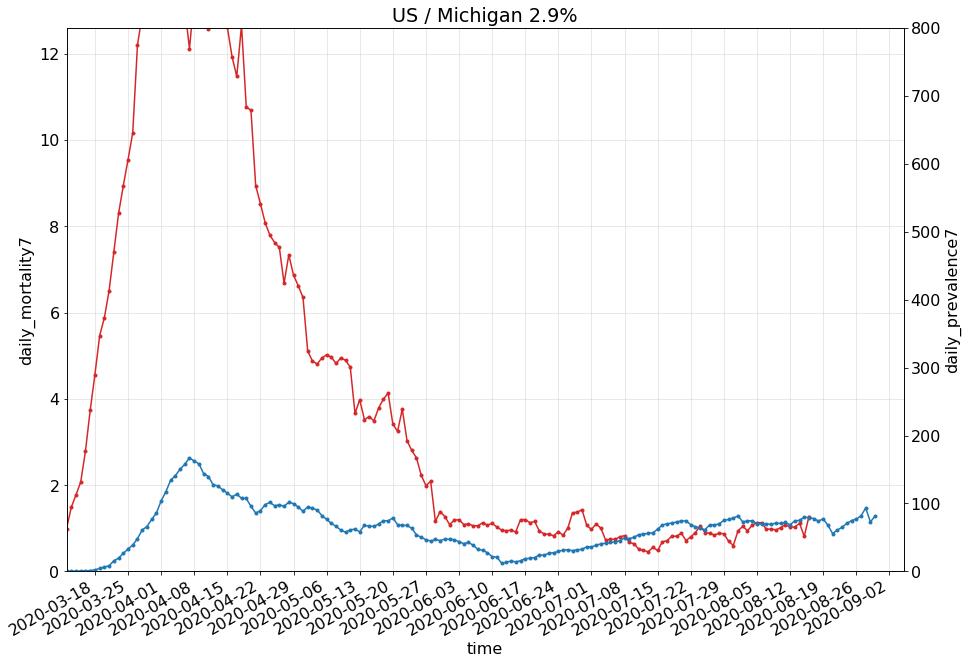

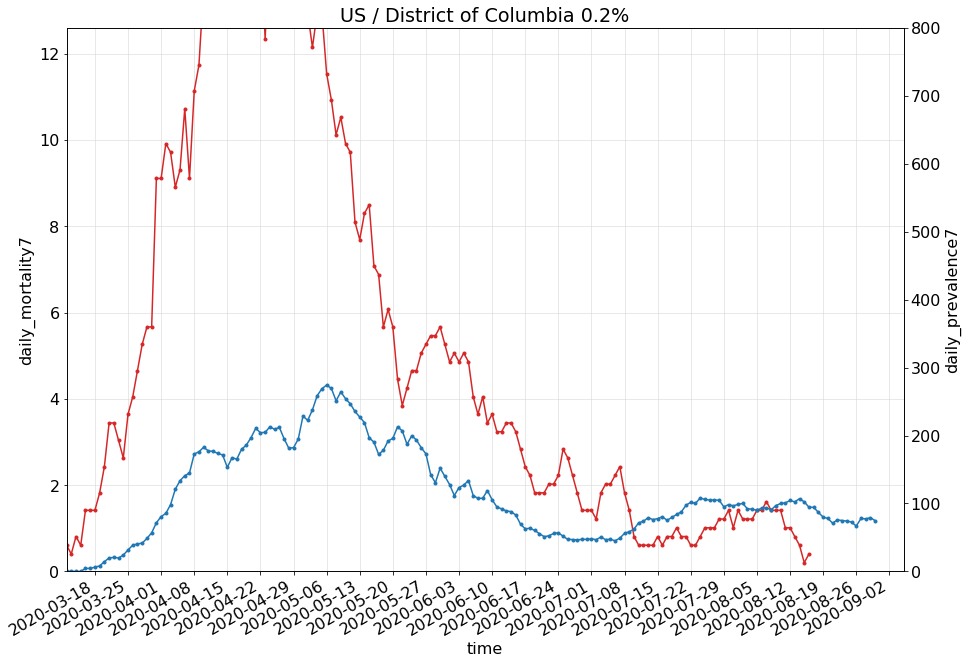

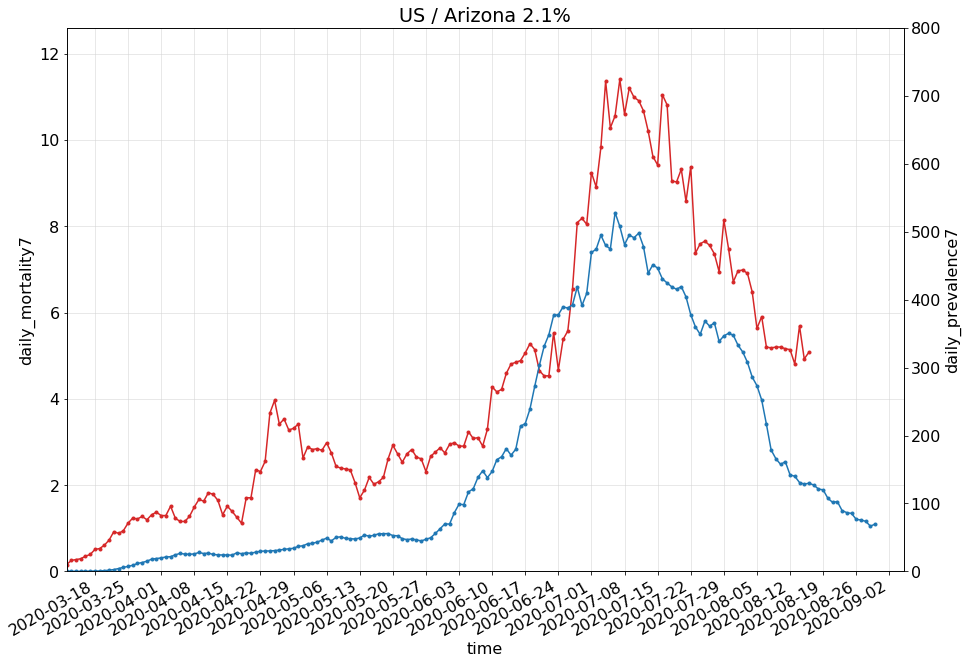

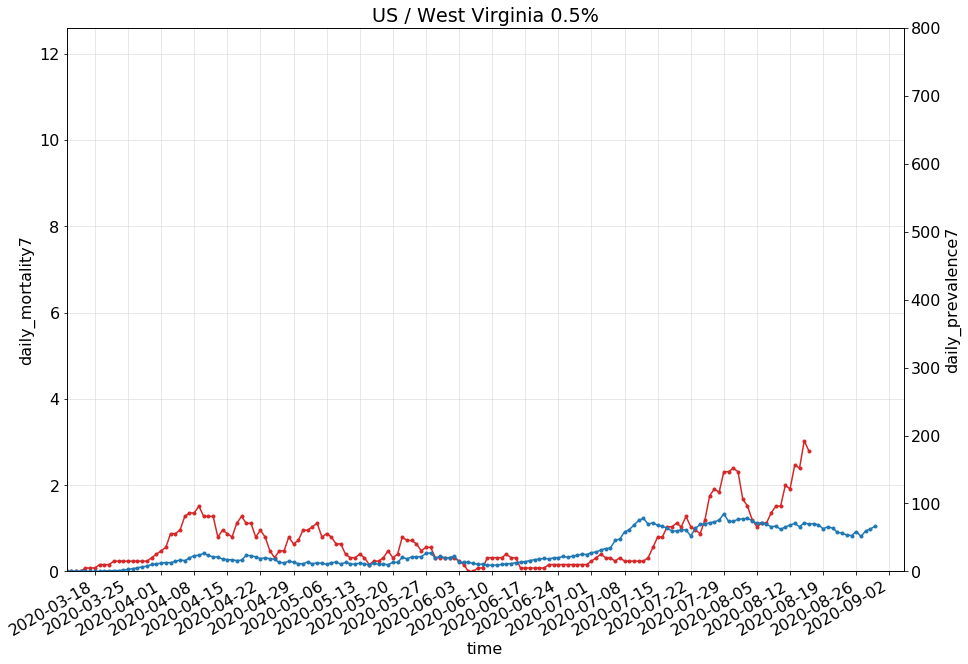

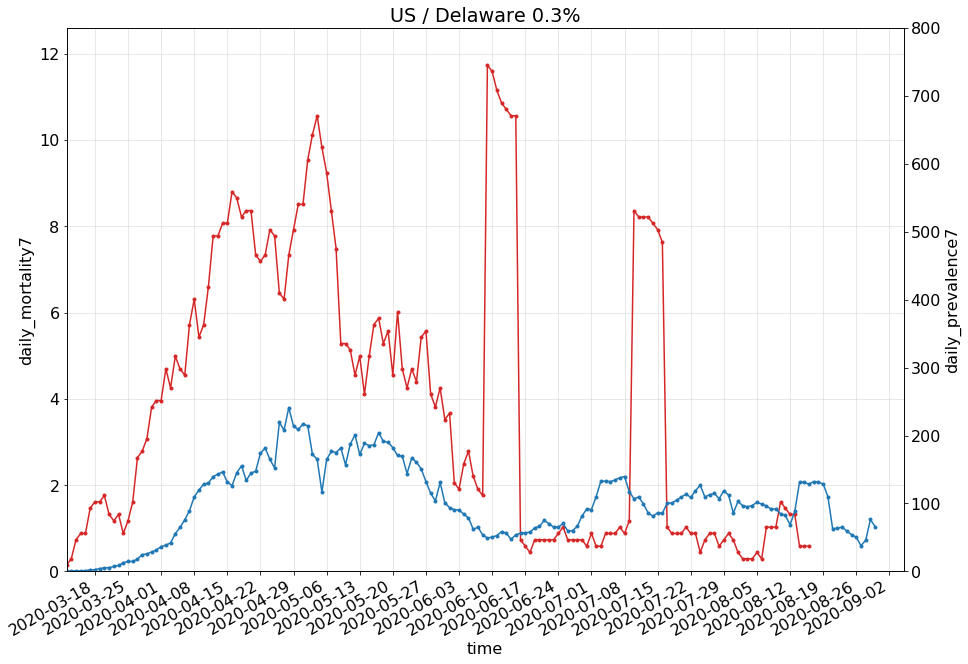

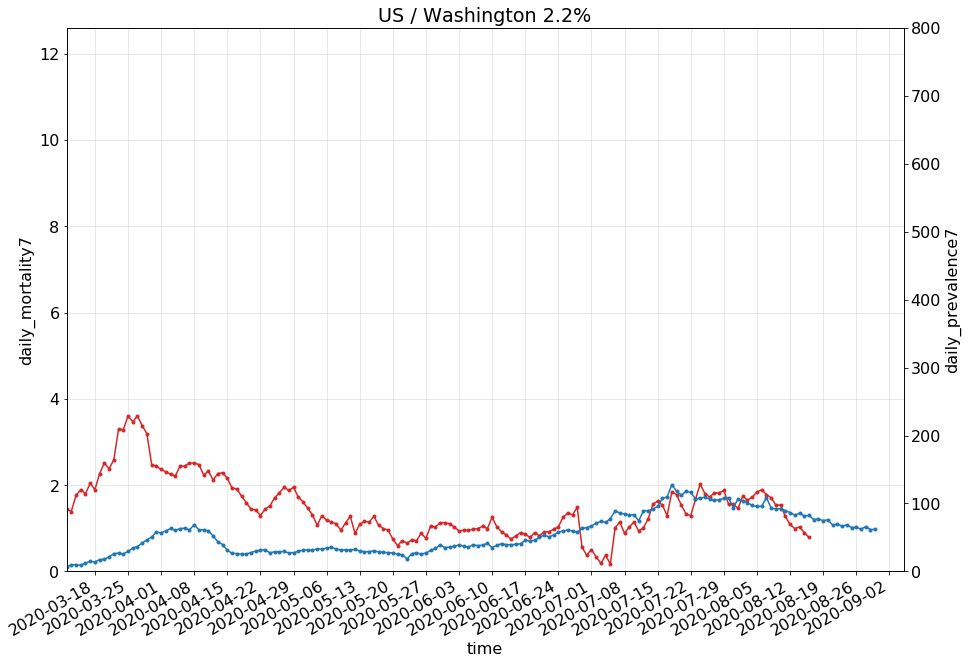

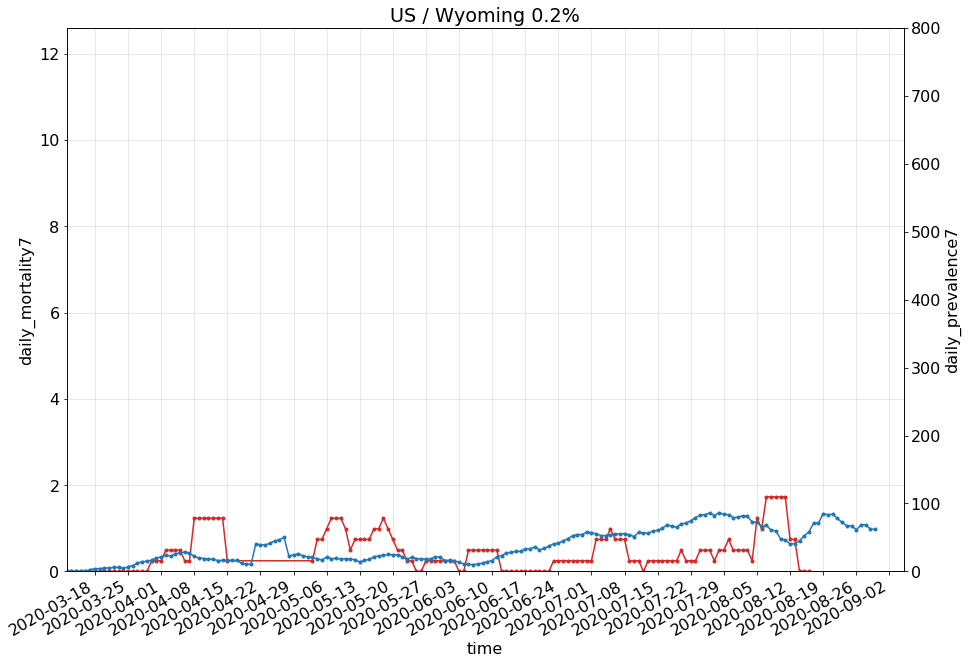

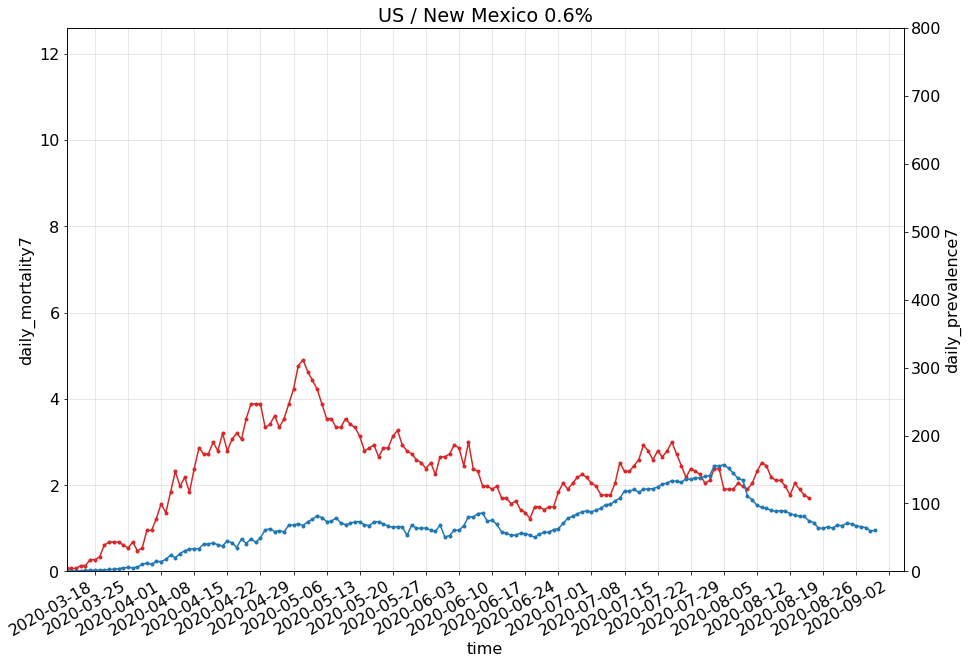

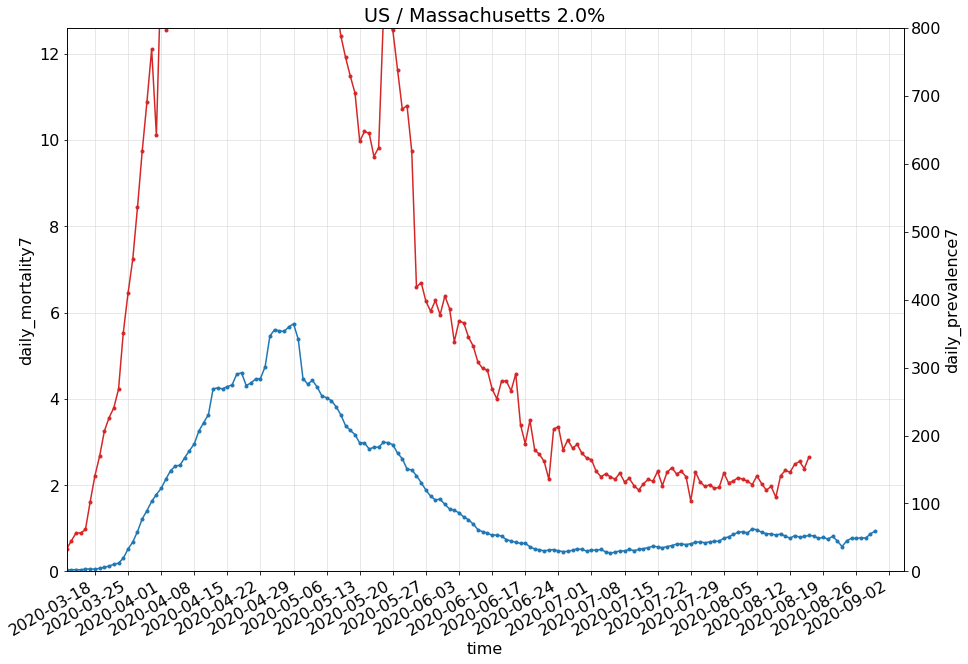

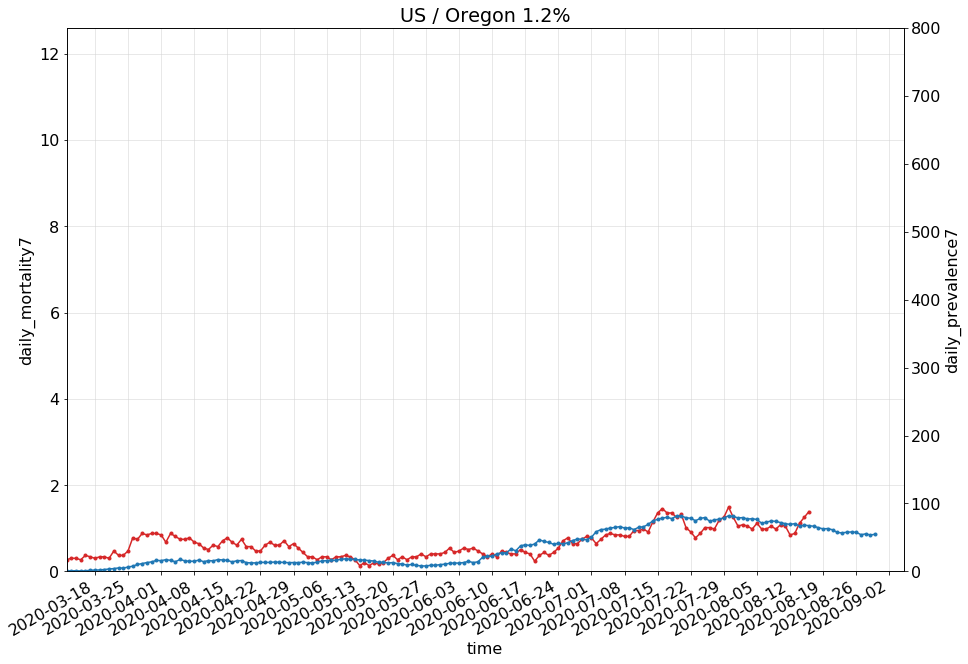

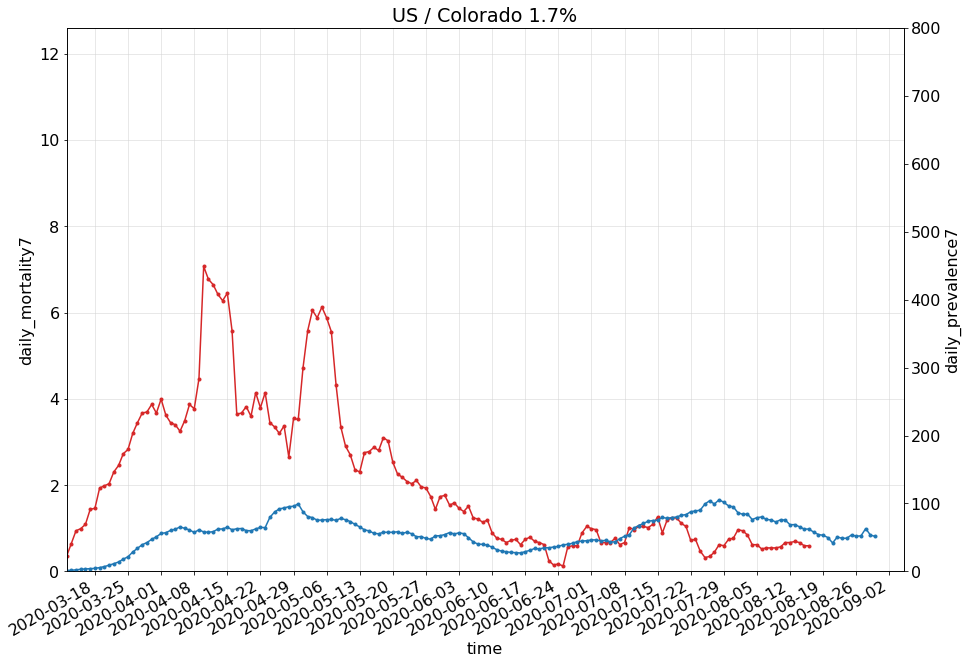

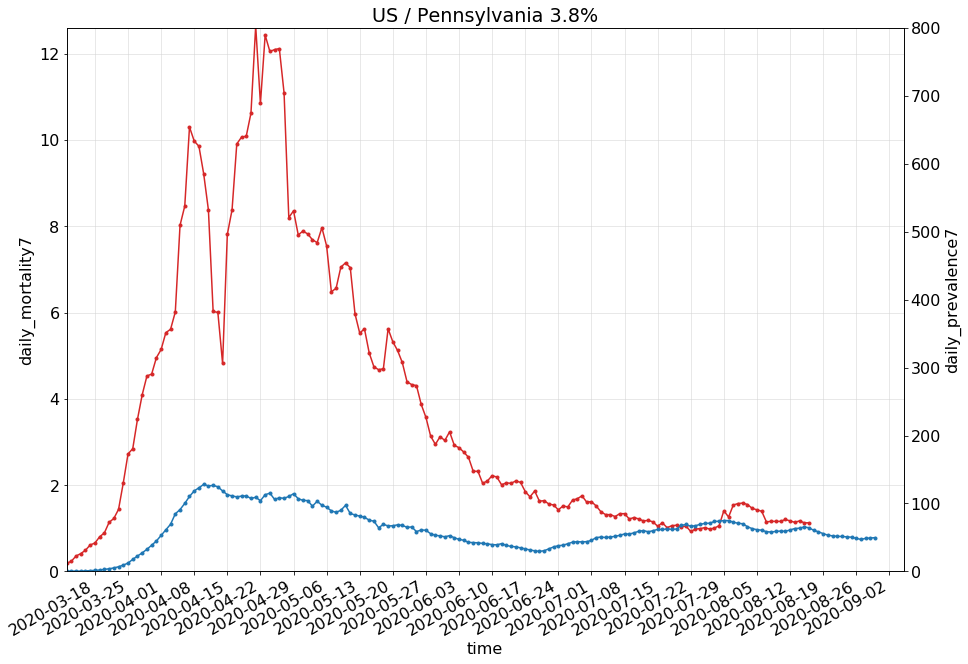

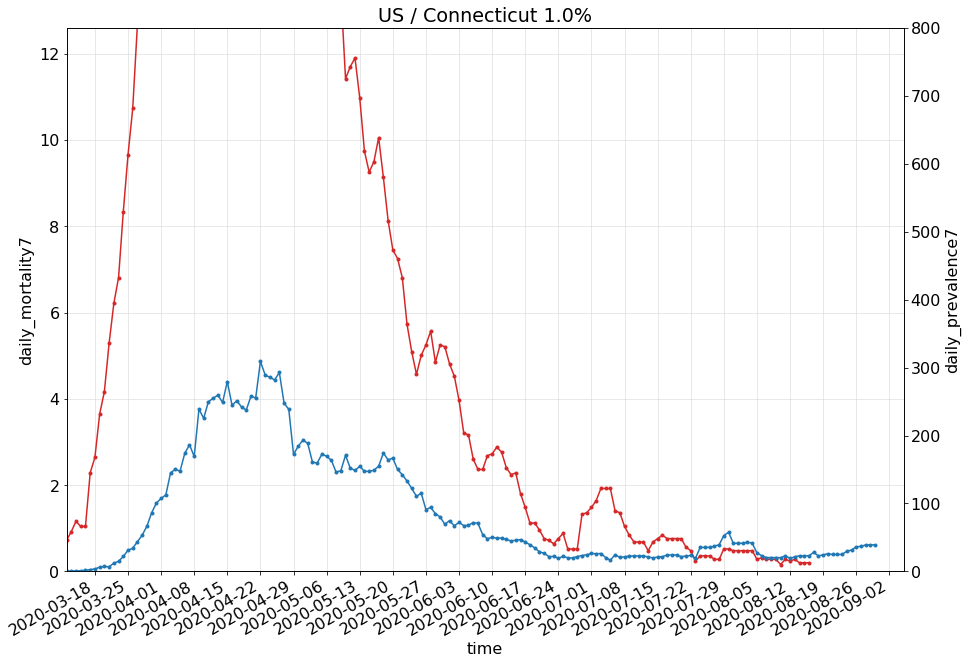

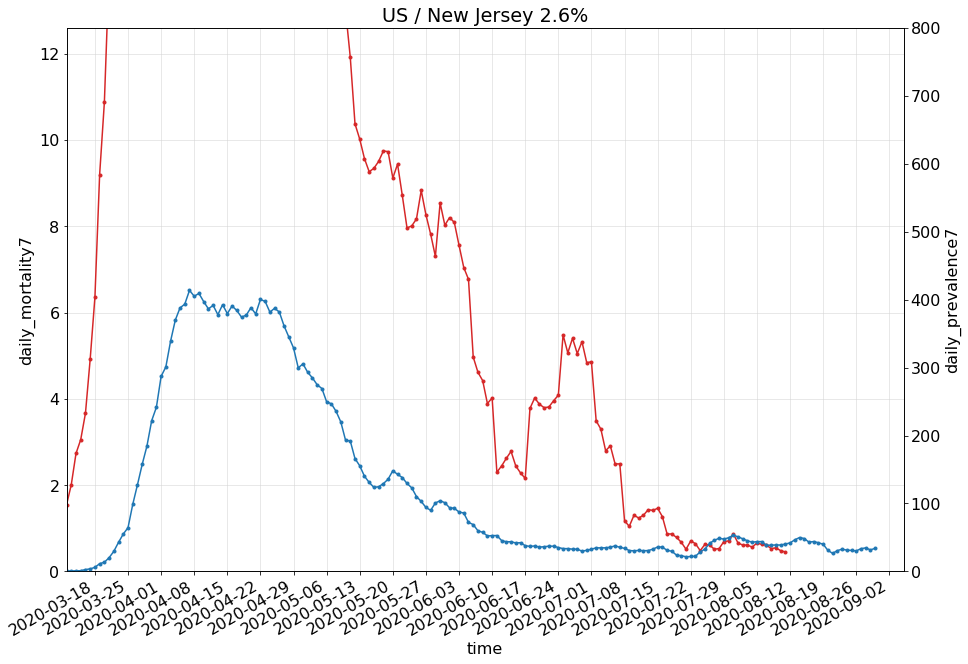

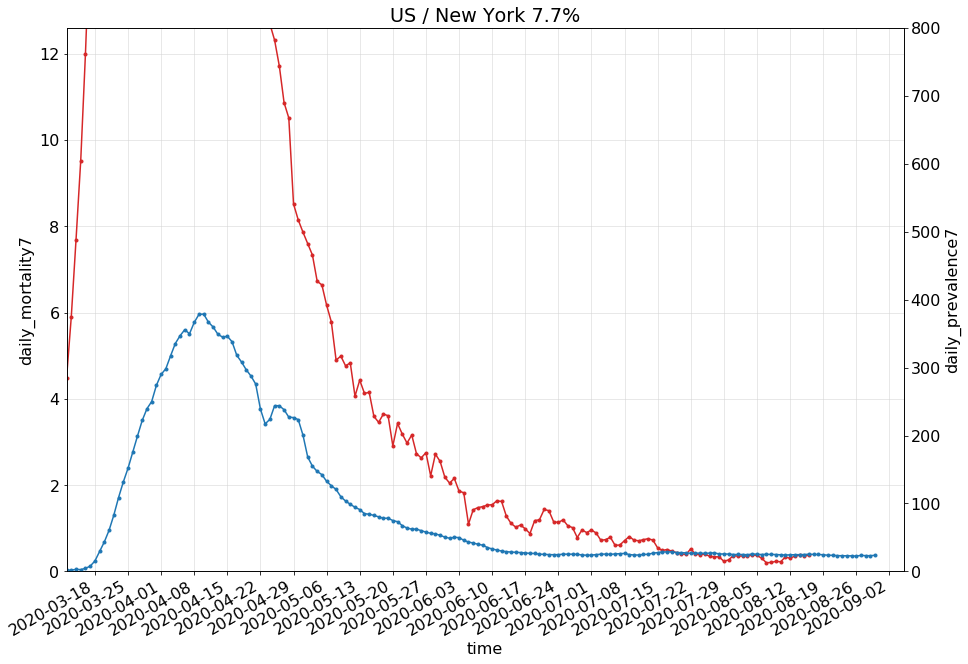

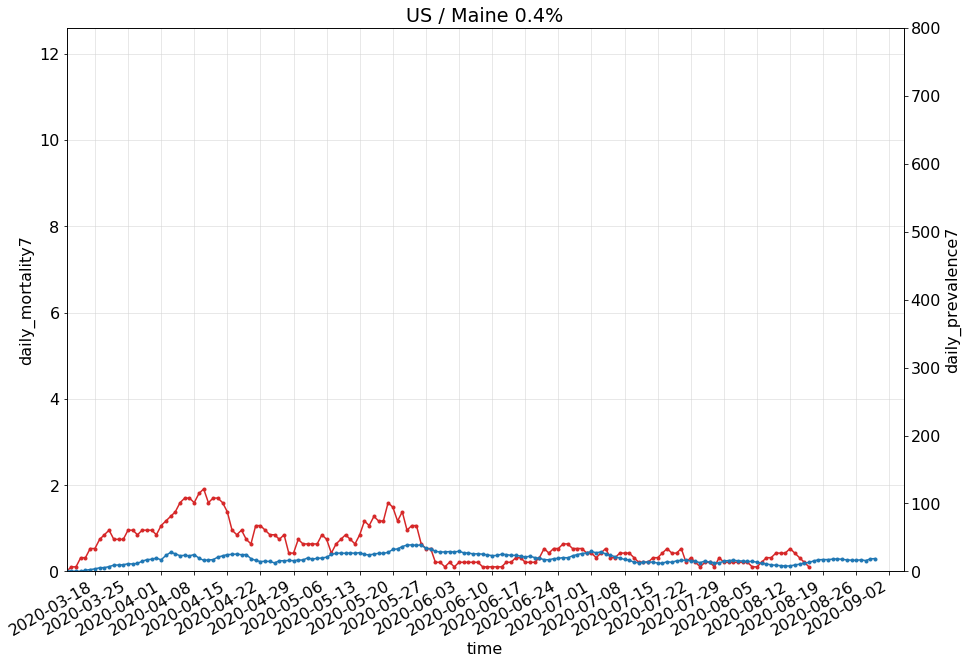

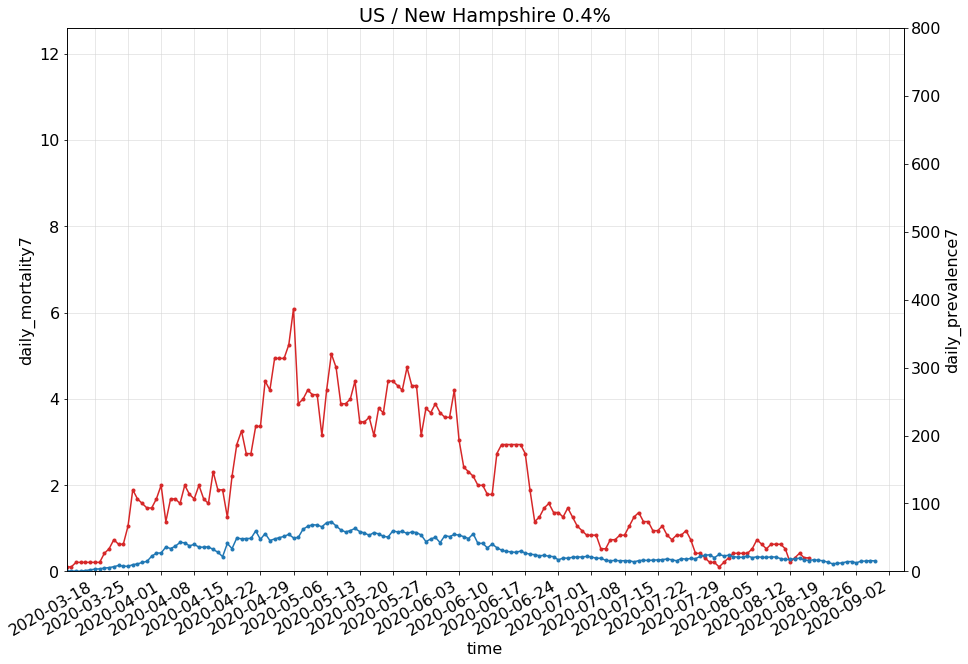

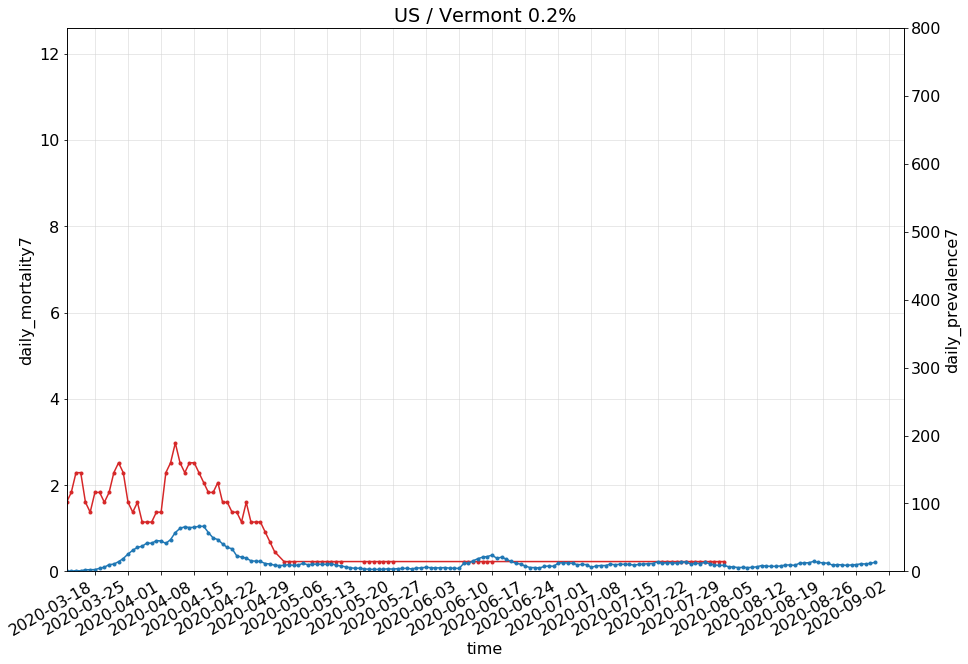

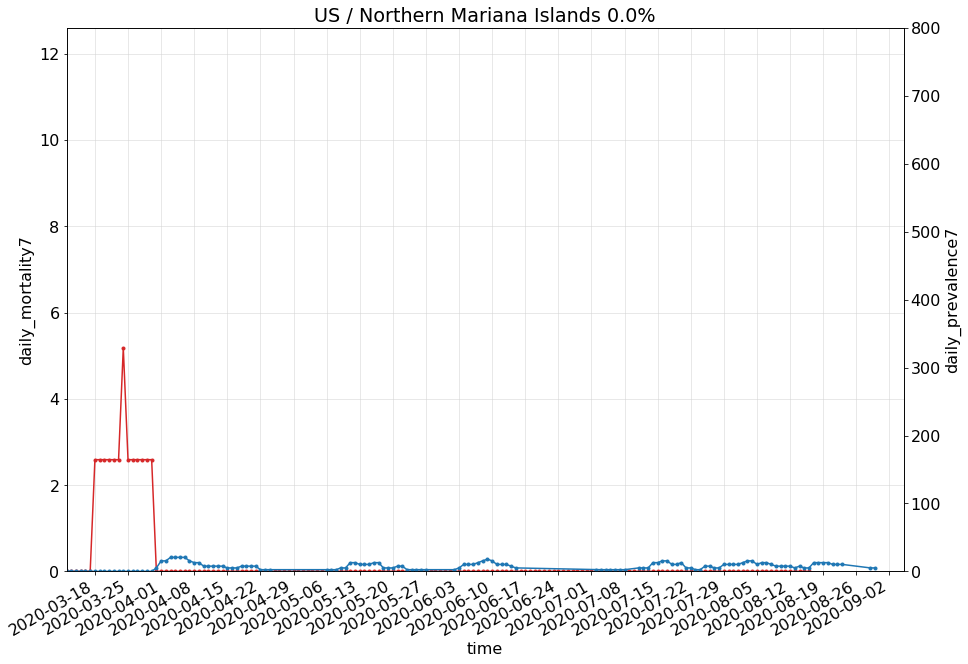

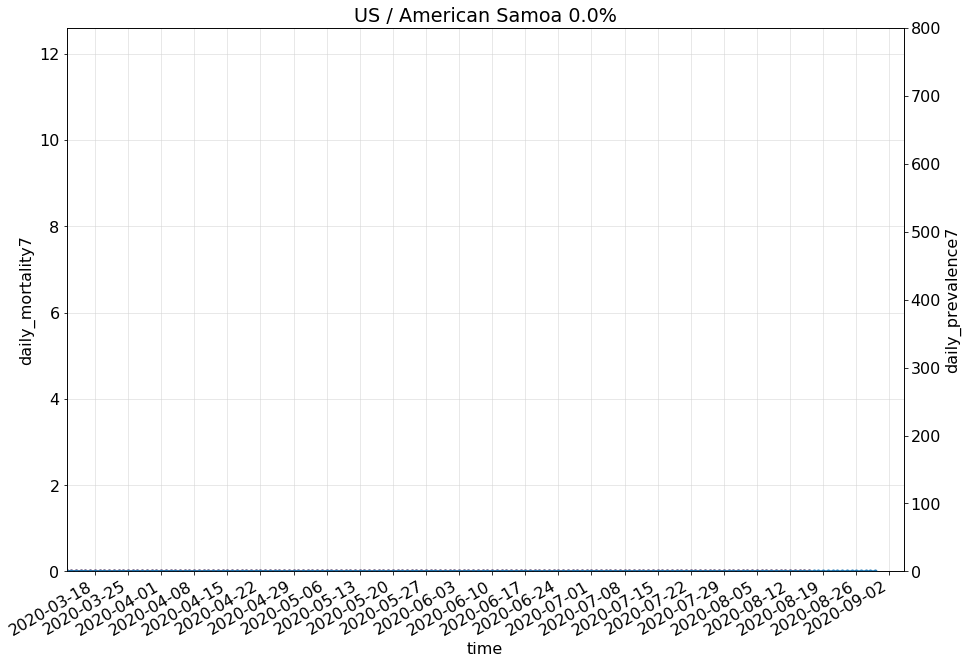

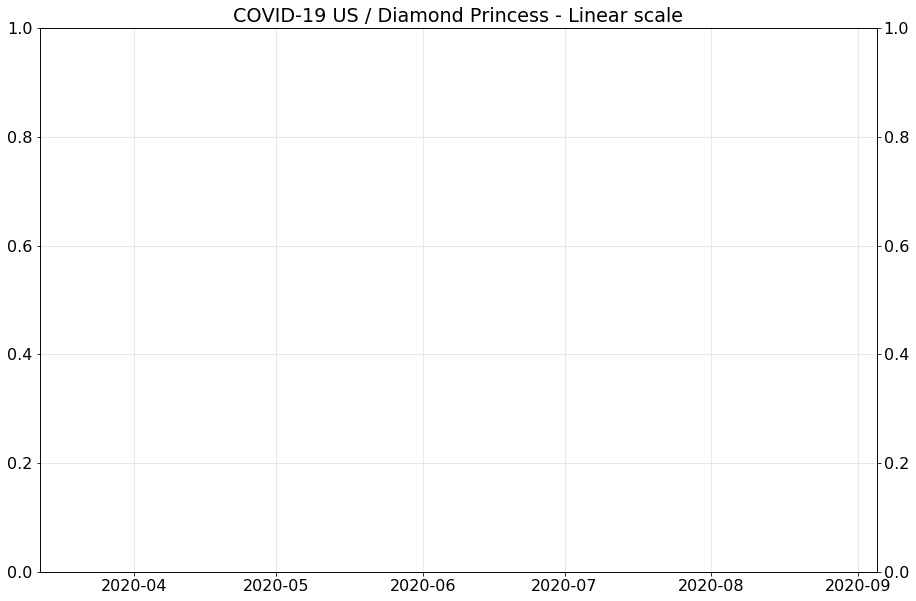

In [134]:
for region in STATES:
    _, ax1 = plt.subplots(subplot_kw={'xlim': XLIM})

    ax1.set_title(f'COVID-19 {region} - Linear scale')
    ax1.yaxis.tick_right()
    ax1.yaxis.grid(color='lightgrey', linewidth=0.5)
    ax1.xaxis.grid(color='lightgrey', linewidth=0.5)

    ds = ds_states.sel(location=region)

    ax2 = ax1.twinx()
    
    covid19.plot.plot_data(ax1, ds['daily_mortality7'], color=PALETTE_ONE[3], delay=-14)
    covid19.plot.plot_data(ax2, ds['daily_prevalence7'], color=PALETTE_ONE[0])

    ax1.set(ylim=(0, 800. * 0.01575), title=f"{region} {ds['population'].values / usa['population'].values * 100:.1f}%")
    ax2.set(ylim=(0, 800.), title=None)